In [222]:
# 라이브러리 기본 참조
from hossam import load_data
from pandas import DataFrame, concat, pivot_table, get_dummies
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
from scipy.stats import t, ttest_ind, normaltest, bartlett, levene
from math import sqrt


# 선형회귀를 위한 참조
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 결과 검정을 위한 참조
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, probplot, shapiro, anderson, pearsonr, spearmanr
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from pingouin import anova, welch_anova, pairwise_tukey, pairwise_gameshowell

# VIF값을 계산하기 위한 참조
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statannotations.Annotator import Annotator

# 파이썬 기본 패키지
from itertools import combinations

In [223]:
origin = load_data("diamonds")
print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print("\n===== 타입확인 =====")
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/kaggle/diamonds.xlsx
[desc] 다이아몬드를 커팅, 색상, 투명도, 가격 및 기타 속성 조사한 데이터 셋 (출처: https://www.kaggle.com/datasets/shivam2503/diamonds)

field    description
-------  -------------------------------------------------------------------
price    다이아몬드 가격 (USD, $326 ~ $18,823)
carat    중량 (0.2~5.01)
cut      컷 품질 (Fair, Good, Very Good, Premium, Ideal)
color    색상 등급 - J (worst) to D (best)
clarity  투명도 등급 (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
x        길이 mm (0~10.74)
y        너비 mm (0--58.9)
z        두께 mm (0--31.8)
depth    비율 정보 = z / mean(x, y) = 2 * z / (x + y) (43--79)
table    다이아몬드의 가장 넓은 지점에 비해 상단(테이블)의 너비 (43--95)


===== 데이터 크기 확인 =====
데이터셋 크기: (53940, 10)
열 개수: 10
행 개수: 53940

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   price    53940 non-null  int64  
 1   carat    53940 

,price,carat,cut,color,clarity,x,y,z,depth,table
0,326,0.23,Ideal,E,SI2,3.95,3.98,2.43,61.5,55.0
1,326,0.21,Premium,E,SI1,3.89,3.84,2.31,59.8,61.0
2,327,0.23,Good,E,VS1,4.05,4.07,2.31,56.9,65.0
3,334,0.29,Premium,I,VS2,4.20,4.23,2.63,62.4,58.0
4,335,0.31,Good,J,SI2,4.34,4.35,2.75,63.3,58.0


In [224]:
origin.describe().T

,count,mean,std,min,25%,50%,75%,max
price,53940.0,3932.799722,3989.439738,326.0,950.00,2401.00,5324.25,18823.00
carat,53940.0,0.797940,0.474011,0.2,0.40,0.70,1.04,5.01
x,53940.0,5.731157,1.121761,0.0,4.71,5.70,6.54,10.74
y,53940.0,5.734526,1.142135,0.0,4.72,5.71,6.54,58.90
z,53940.0,3.538734,0.705699,0.0,2.91,3.53,4.04,31.80
depth,53940.0,61.749405,1.432621,43.0,61.00,61.80,62.50,79.00
table,53940.0,57.457184,2.234491,43.0,56.00,57.00,59.00,95.00


In [225]:
df = origin.copy()
df.isna().sum()

price      0
carat      0
cut        0
color      0
clarity    0
x          0
y          0
z          0
depth      0
table      0
dtype: int64

In [226]:
for i in ["cut", "color", "clarity"]:
    print(df[i].unique())

['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
['E' 'I' 'J' 'H' 'F' 'G' 'D']
['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']


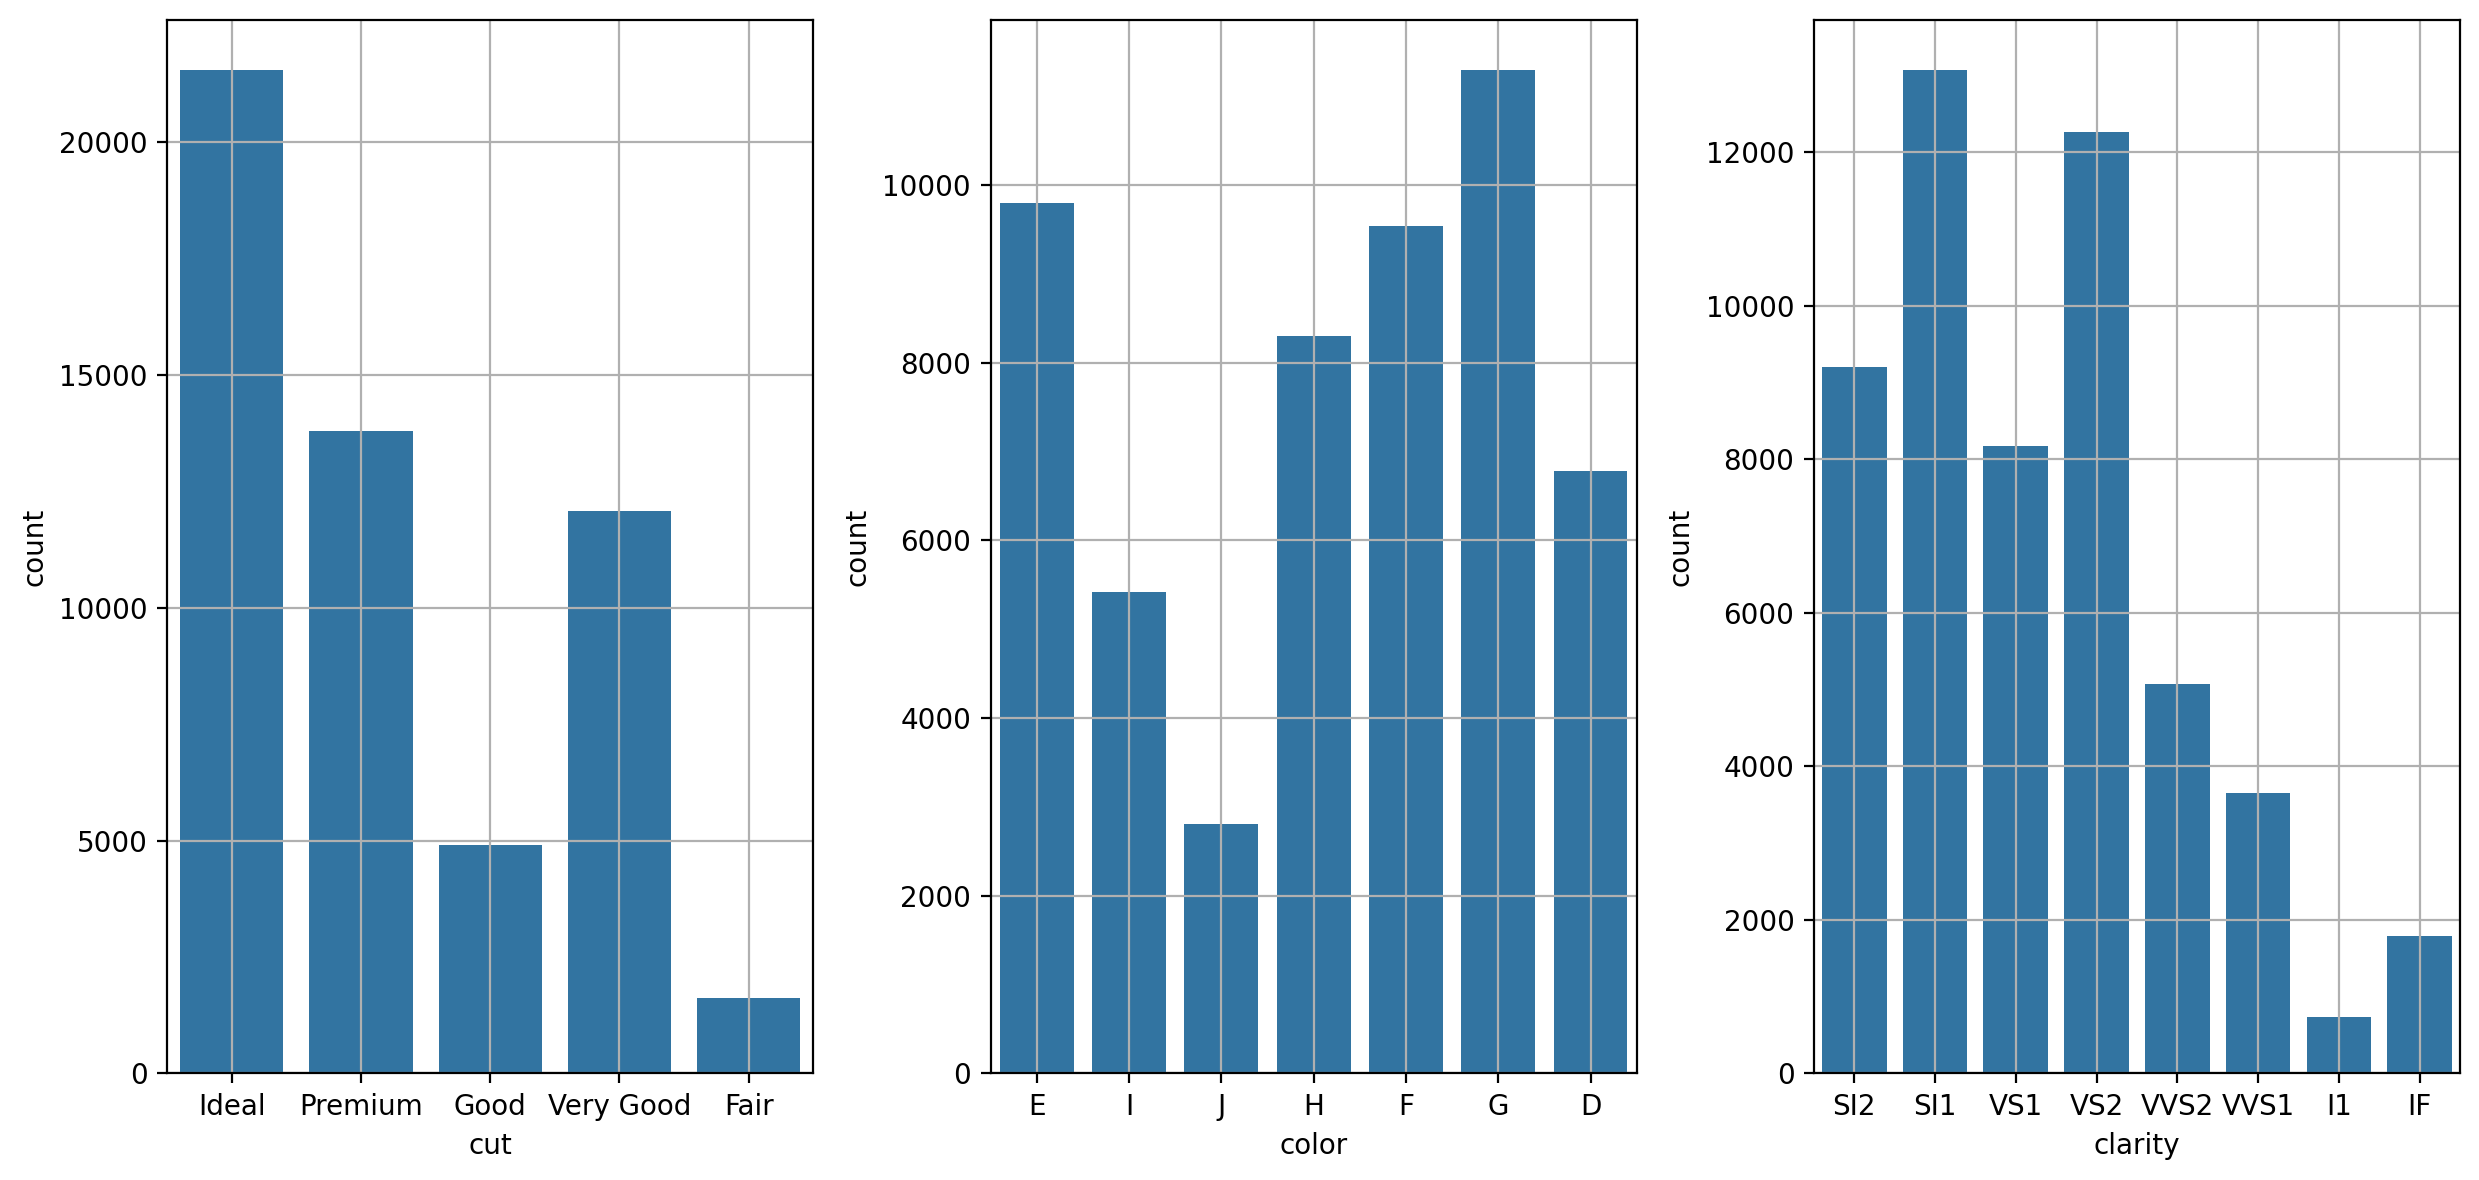

In [227]:
data = ["cut", "color", "clarity"]

# 1) 그래프 초기화 (밖에서 한 번만)
rows = 1
cols = len(data)
width_px = 2500
height_px = 1200
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기
for i, v in enumerate(data):
    sb.countplot(data=df, x=v, ax=ax[i])
    ax[i].grid(True)

plt.tight_layout()
plt.show()
plt.close()

In [228]:
xyz = ["x", "y", "z"]
((df[xyz] == 0).sum(axis=1) > 0).sum()

np.int64(20)

In [229]:
((df[xyz] < 0).sum(axis=1) > 0).sum()

np.int64(0)

In [230]:
df1 = df[(df[xyz] != 0).all(axis=1)]
df1

,price,carat,cut,color,clarity,x,y,z,depth,table
0,326,0.23,Ideal,E,SI2,3.95,3.98,2.43,61.5,55.0
1,326,0.21,Premium,E,SI1,3.89,3.84,2.31,59.8,61.0
2,327,0.23,Good,E,VS1,4.05,4.07,2.31,56.9,65.0
3,334,0.29,Premium,I,VS2,4.20,4.23,2.63,62.4,58.0
4,335,0.31,Good,J,SI2,4.34,4.35,2.75,63.3,58.0
...,...,...,...,...,...,...,...,...,...,...
53935,2757,0.72,Ideal,D,SI1,5.75,5.76,3.50,60.8,57.0
53936,2757,0.72,Good,D,SI1,5.69,5.75,3.61,63.1,55.0
53937,2757,0.70,Very Good,D,SI1,5.66,5.68,3.56,62.8,60.0
53938,2757,0.86,Premium,H,SI2,6.15,6.12,3.74,61.0,58.0


In [231]:
df1 = df[(df[xyz] != 0).all(axis=1)]
df1

,price,carat,cut,color,clarity,x,y,z,depth,table
0,326,0.23,Ideal,E,SI2,3.95,3.98,2.43,61.5,55.0
1,326,0.21,Premium,E,SI1,3.89,3.84,2.31,59.8,61.0
2,327,0.23,Good,E,VS1,4.05,4.07,2.31,56.9,65.0
3,334,0.29,Premium,I,VS2,4.20,4.23,2.63,62.4,58.0
4,335,0.31,Good,J,SI2,4.34,4.35,2.75,63.3,58.0
...,...,...,...,...,...,...,...,...,...,...
53935,2757,0.72,Ideal,D,SI1,5.75,5.76,3.50,60.8,57.0
53936,2757,0.72,Good,D,SI1,5.69,5.75,3.61,63.1,55.0
53937,2757,0.70,Very Good,D,SI1,5.66,5.68,3.56,62.8,60.0
53938,2757,0.86,Premium,H,SI2,6.15,6.12,3.74,61.0,58.0


In [232]:
((df1[xyz] == 0).sum(axis=1) > 0).sum()

np.int64(0)

x, y, z 중 하나라도 0인 관측치가 20개 확인되었고, 0 이하(음수) 값은 없었다.

다이아몬드는 물리적 실체를 가지므로 길이(x), 너비(y), 깊이(z) 중 하나라도 0인 값은 현실적으로 불가능한 기록(측정 오류)로 판단하였다.

따라서 x, y, z 중 하나라도 0인 관측치는 제거한 후 분석을 진행하였다.

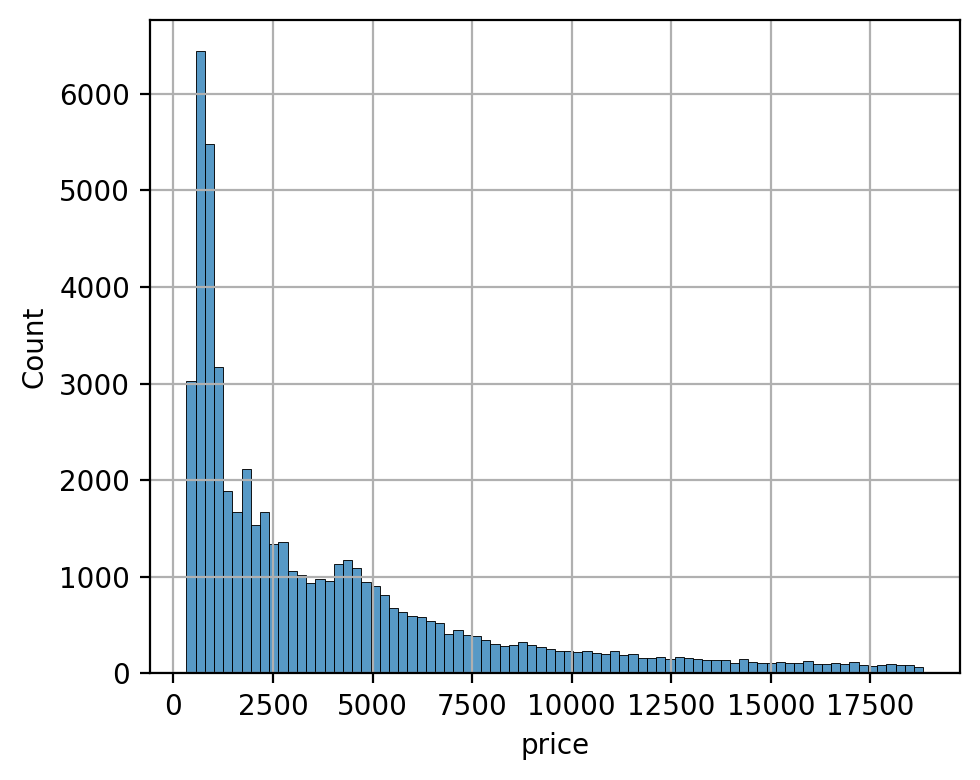

In [233]:
# 1) 그래프 초기화 (캔바스(fig)와 도화지(ax) 준비하기)
width_px = 1000
height_px = 800
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.histplot(data=df1, x="price")

# 3) 그래프 꾸미기
ax.grid(True)


plt.tight_layout()
plt.show()
plt.close()

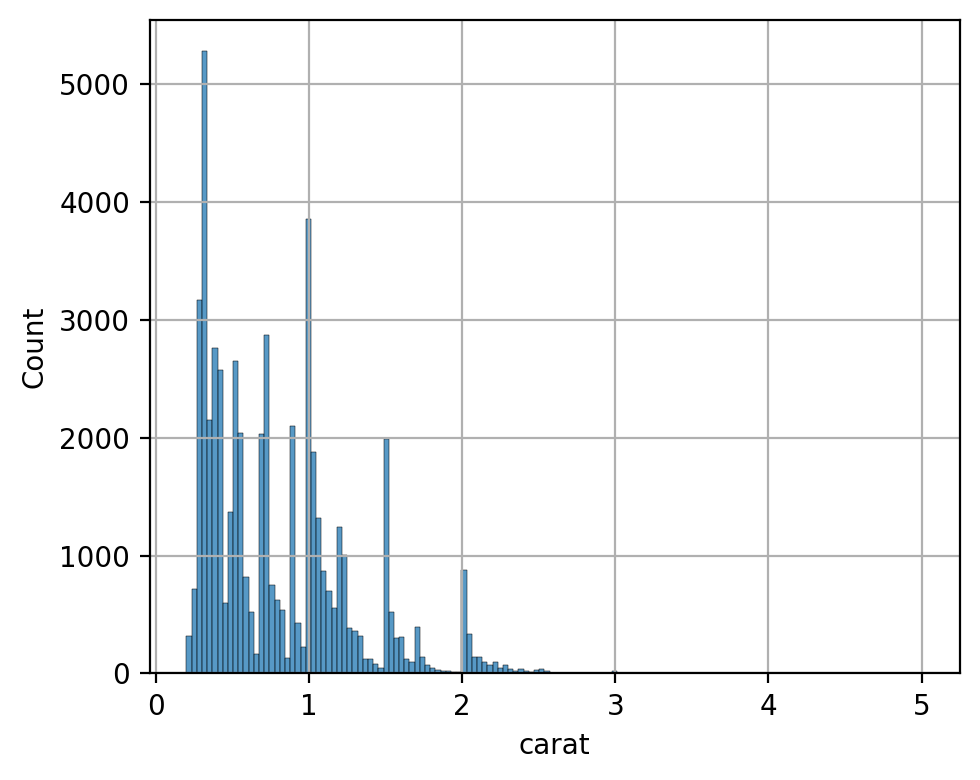

In [234]:
# 1) 그래프 초기화
width_px = 1000
height_px = 800
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기
sb.histplot(data=df1, x="carat")

# 3) 그래프 꾸미기
ax.grid(True)


plt.tight_layout()
plt.show()
plt.close()

price와 carat의 분포를 확인한 결과, 두 변수 모두 낮은 값에 데이터가 몰려 있고 높은 값 방향으로 꼬리가 길게 나타났다. 이런 형태는 정규분포와는 거리가 있어 보이므로, 그대로 회귀분석을 진행하면 잔차도 한쪽으로 치우쳐 해석이 어려울 수 있다. 따라서 회귀를 바로 진행하기보다는 로그 변환처럼 분포를 완화하는 방법을 검토할 필요가 있다.

In [235]:
df2 = df1.copy()
df2["log_price"] = np.log(df2["price"])
df2["log_carat"] = np.log(df2["carat"])
df2.head()

,price,carat,cut,color,clarity,x,y,z,depth,table,log_price,log_carat
0,326,0.23,Ideal,E,SI2,3.95,3.98,2.43,61.5,55.0,5.786897,-1.469676
1,326,0.21,Premium,E,SI1,3.89,3.84,2.31,59.8,61.0,5.786897,-1.560648
2,327,0.23,Good,E,VS1,4.05,4.07,2.31,56.9,65.0,5.789960,-1.469676
3,334,0.29,Premium,I,VS2,4.20,4.23,2.63,62.4,58.0,5.811141,-1.237874
4,335,0.31,Good,J,SI2,4.34,4.35,2.75,63.3,58.0,5.814131,-1.171183


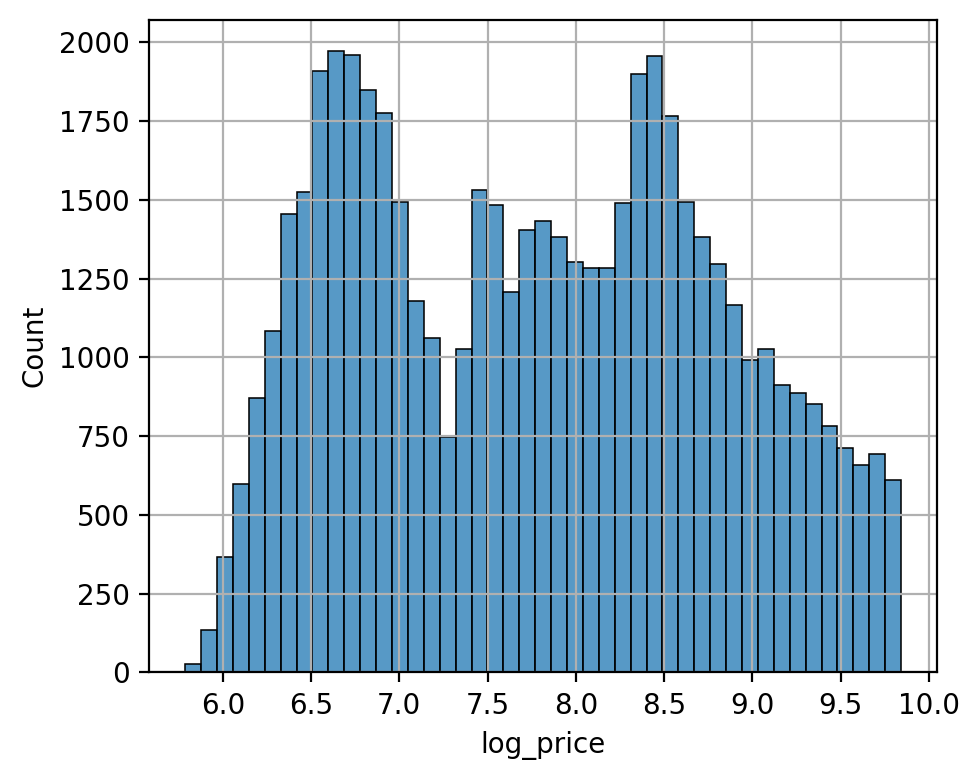

In [236]:
# 1) 그래프 초기화
width_px = 1000
height_px = 800
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기
sb.histplot(data=df2, x="log_price")

# 3) 그래프 꾸미기
ax.grid(True)


plt.tight_layout()
plt.show()
plt.close()

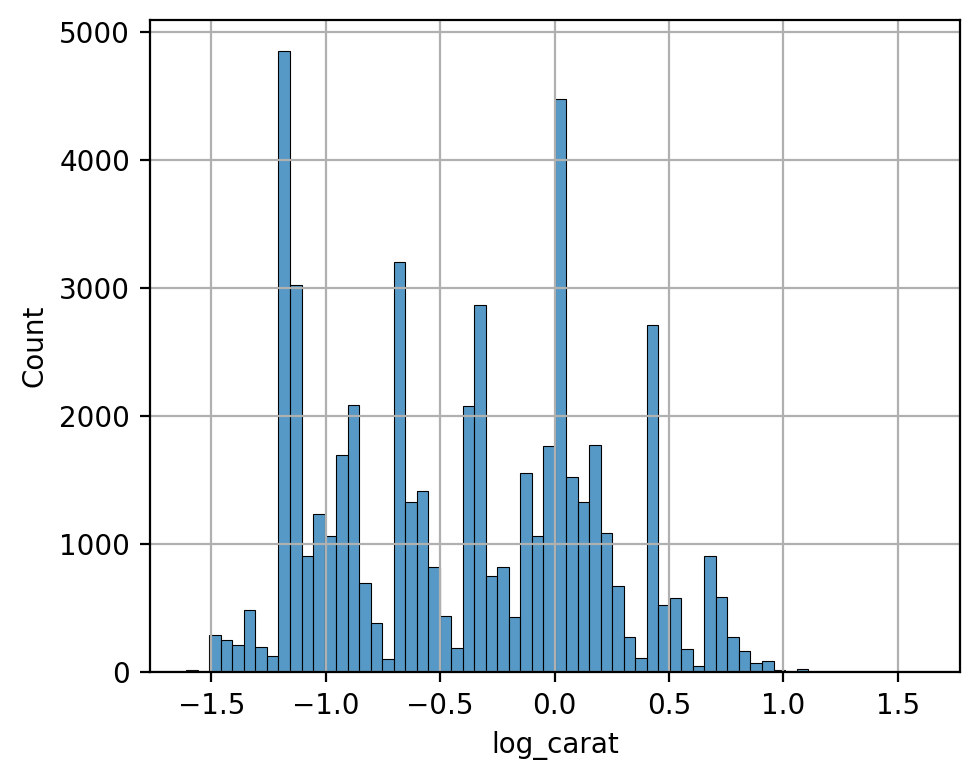

In [237]:
# 1) 그래프 초기화
width_px = 1000
height_px = 800
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기
sb.histplot(data=df2, x="log_carat")

# 3) 그래프 꾸미기
ax.grid(True)


plt.tight_layout()
plt.show()
plt.close()

price와 carat에 로그 변환을 적용한 결과, 큰 값은 상대적으로 압축되고 작은 값은 비교적 덜 변하여 스케일 차이가 완화되었다. 변환 후 히스토그램에서는 변환 전보다 오른쪽으로 길게 늘어진 꼬리가 줄어든 모습을 확인할 수 있으며, 이는 극단적으로 큰 값이 전체 분석에 미치는 영향이 감소했음을 의미한다. 따라서 로그 변환은 분포를 완전히 정규화하기 위한 목적이라기보다, 치우친 분포를 완화하고 이후 회귀/검정의 안정성을 높이기 위한 전처리로 사용하였다.

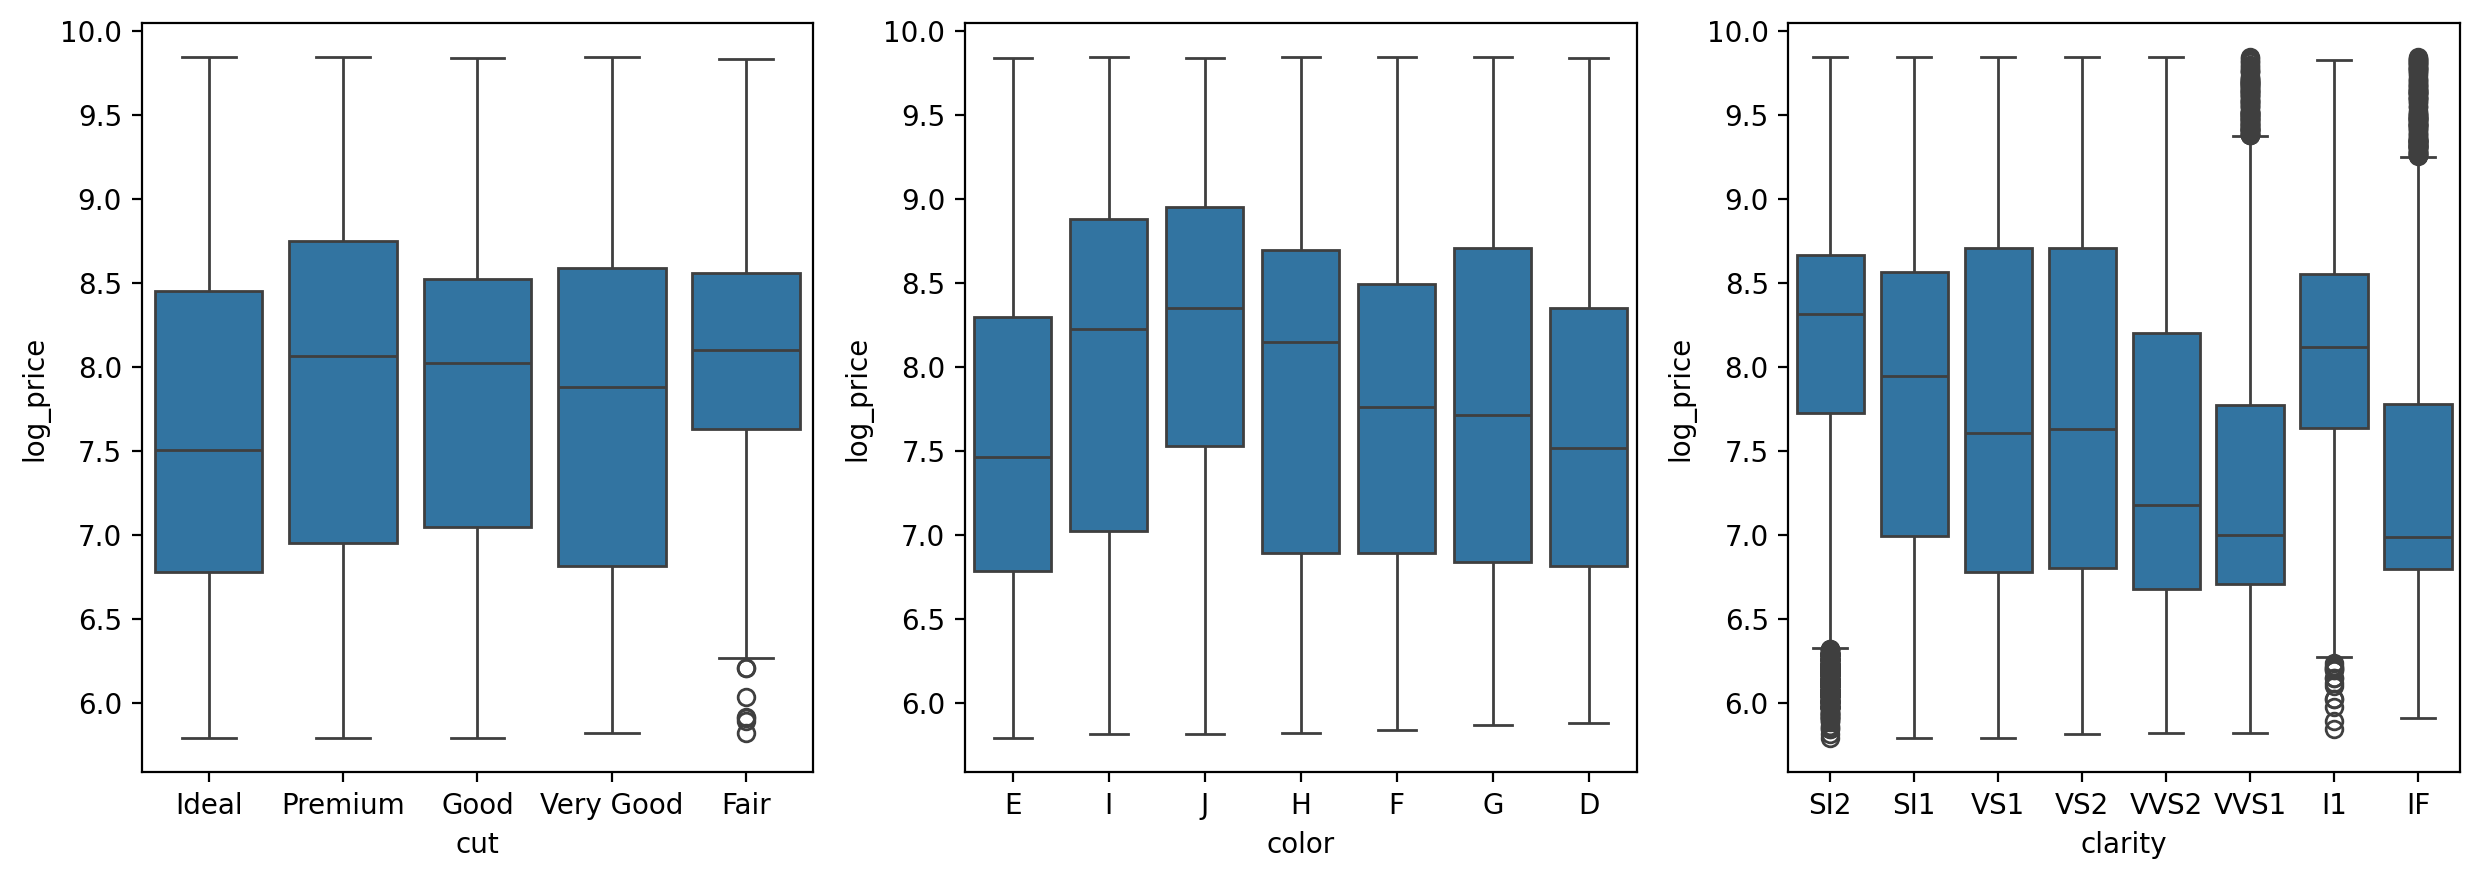

In [238]:
data = ["cut", "color", "clarity"]


# 1) 그래프 초기화
rows = 1
cols = len(data)
width_px = 2500
height_px = 900
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기
for i, v in enumerate(data):
    sb.boxplot(data=df2, x=v, y="log_price", ax=ax[i])

plt.tight_layout()
plt.show()
plt.close()

cut 기준으로는 Premium의 중앙값이 상대적으로 높고, 박스 폭도 넓어 가격 변동(분산)이 큰 편으로 보인다. Fair는 박스 폭은 비교적 좁지만 이상치가 관찰되어 일부 극단값이 존재함을 확인할 수 있다.

color는 등급 간 가격 분포가 많이 겹쳐, 색상 등급만으로 가격을 뚜렷하게 구분하기 어렵다.

clarity 역시 분포 겹침이 존재해 단독으로 가격을 완전히 가르긴 어렵지만, 세 품질 변수 중에서는 등급별 중앙값 차이가 상대적으로 더 뚜렷하게 나타나 가격 차이를 가장 잘 보여주는 변수로 관찰된다.

결론적으로, 가격 차이가 비교적 뚜렷한 품질 변수는 clarity이고, color는 등급 간 분포 겹침이 커 등급이 달라도 비슷한 가격 구간이 많이 나타난다.

boxplot에서 일부 극단값이 관찰되었으나, 본 데이터는 가격/중량 분포가 본질적으로 오른쪽으로 긴 꼬리를 가지는 시장 데이터이며, boxplot의 outlier 표시는 IQR 기준의 상대적 극단값을 의미할 뿐 측정 오류를 의미하지 않는다. 따라서 물리적으로 불가능한 값(x,y,z=0)과 같은 명확한 오류만 제거하고, 그 외 극단값은 실제 희귀 관측치일 가능성이 높아 임의 제거는 하지 않았다. 대신 로그 변환을 통해 극단값의 영향력을 통제하였다.

In [239]:
df3 = (
    df2.query("cut == 'Premium' or cut == 'Ideal'")[["cut", "log_price"]]
    .dropna()
    .copy()
)

premium = df3.loc[df3["cut"] == "Premium", "log_price"].reset_index(drop=True)
ideal = df3.loc[df3["cut"] == "Ideal", "log_price"].reset_index(drop=True)

df4 = concat([premium, ideal], axis=1)
df4.columns = ["Premium", "Ideal"]
df4

,Premium,Ideal
0,5.786897,5.786897
1,5.811141,5.828946
2,5.834811,5.840642
3,5.843544,5.852202
4,5.843544,5.998937
...,...,...
21543,NaN,7.921536
21544,NaN,7.921536
21545,NaN,7.921536
21546,NaN,7.921898


In [240]:
data = df4[["Premium", "Ideal"]]

equal_var_fields = []
normal_dist = True
report = []

for c in data.columns:
    x = data[c].dropna()  # 결측치 제거

    s, p = normaltest(x)
    normalize = p > 0.05

    report.append({"field": c, "statistic": s, "p-value": p, "result": normalize})

    normal_dist = normal_dist and normalize
    equal_var_fields.append(x)

# 정규성 결과에 따라 등분산 검정 선택
if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*equal_var_fields)
else:
    n = "Levene"
    s, p = levene(*equal_var_fields, center="median")

equal_var = p > 0.05

report.append({"field": n, "statistic": s, "p-value": p, "result": equal_var})

report_df = DataFrame(report).set_index("field")
report_df

,statistic,p-value,result
field,,,
Premium,9971.943330,0.000000e+00,False
Ideal,4631.300567,0.000000e+00,False
Levene,72.949864,1.382238e-17,False


Premium과 Ideal의 log_price에 대해 정규성 검정을 수행한 결과 두 그룹 모두 p-value≈0으로 정규성 가정이 충족되지 않았고, Levene 검정에서도 p<0.05 이므로 등분산 가정이 위배되었다.
따라서 등분산 가정 없이 평균 차이를 비교할 수 있는 Welch t-test를 적용한다.

In [241]:
s, p = ttest_ind(
    df4["Premium"].dropna(),
    df4["Ideal"].dropna(),
    equal_var=False,
    alternative="greater",
)

result = "statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(
    s, p, "대립" if p <= 0.05 else "귀무"
)
print(result)

statistic: 28.053, p-value: 0.000, 대립가설 채택


Premium과 Ideal의 가격 차이를 확인하기 위해 두 집단 평균 비교를 수행하였다. 가격은 오른쪽 꼬리가 긴 분포를 가지므로 극단값 영향을 완화하기 위해 log 변환된 가격(log_price)을 사용하였다.   
Premium과 Ideal의 평균(log_price) 차이를 검정하기 위해 t-test를 수행하였으며, 가격 데이터 특성상 두 집단의 분산이 동일하다고 가정하기 어렵고 표본 수 또한 다를 수 있어 등분산 가정을 필요로 하지 않는 Welch t-test를 적용하였다. 그 결과 p = 3.79e-171 (p < 0.05)로 귀무가설을 기각하였으며, 따라서 Premium의 평균(log_price)은 Ideal보다 통계적으로 유의하게 더 크다.

In [242]:
df6 = df2[["cut", "log_price"]].dropna().copy()
df6

,cut,log_price
0,Ideal,5.786897
1,Premium,5.786897
2,Good,5.789960
3,Premium,5.811141
4,Good,5.814131
...,...,...
53935,Ideal,7.921898
53936,Good,7.921898
53937,Very Good,7.921898
53938,Premium,7.921898


In [243]:
field = "log_price"
hue_field = "cut"

df = df6[[field, hue_field]].copy()
df["idx"] = df.groupby(hue_field).cumcount()

data = pivot_table(df, index="idx", columns=hue_field, values=field, aggfunc="first")


normal_dist = True
report = []
values = []

for c in data.columns:
    target = data[c].dropna()
    values.append(target)

    s, p = normaltest(target)
    normalize = p > 0.05
    report.append({"field": c, "statistic": s, "p-value": p, "result": normalize})
    normal_dist = normal_dist and normalize

# 등분산성
if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*values)
else:
    n = "Levene"
    s, p = levene(*values, center="median")

equal_var = p > 0.05
report.append({"field": n, "statistic": s, "p-value": p, "result": equal_var})

report_df = DataFrame(report).set_index("field")
report_df

,statistic,p-value,result
field,,,
Fair,5.576223,6.153730e-02,True
Good,709.824985,7.302353e-155,False
Ideal,4631.300567,0.000000e+00,False
Premium,9971.943330,0.000000e+00,False
Very Good,4704.114948,0.000000e+00,False
Levene,122.580235,2.492832e-104,False


cut별 log_price 분포에 대해 가정 검정을 수행한 결과, 정규성 검정에서는 대부분의 cut에서 p-value가 매우 작아 정규성을 만족한다고 보기 어려웠다. 또한 Levene 등분산성 검정에서도 p = 2.49e-104로 등분산성이 명확히 위배되었다.
따라서 등분산을 전제로 하는 일반 일원분산분석(One-way ANOVA)보다는, 등분산 가정 없이 cut 간 평균 차이를 검정할 수 있는 Welch ANOVA를 적용하는 것이 타당하다.

In [244]:
s, p = ttest_ind(
    df4["Premium"].dropna(),
    df4["Ideal"].dropna(),
    equal_var=False,
    alternative="greater",
)

result = "statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(
    s, p, "대립" if p <= 0.05 else "귀무"
)
print(result)

statistic: 28.053, p-value: 0.000, 대립가설 채택


In [245]:
anova_df = df6[[field, hue_field]]

if equal_var:
    pg_anova = anova(data=anova_df, dv=field, between=hue_field)
else:
    pg_anova = welch_anova(data=anova_df, dv=field, between=hue_field)

display(pg_anova)

f_val = pg_anova["F"].iloc[0]
p_val = pg_anova["p-unc"].iloc[0]
print(
    "statistic: {0:.3f}, p-value: {1:.3g}, {2}가설 채택".format(
        f_val, p_val, "대립" if p_val <= 0.05 else "귀무"
    )
)

if equal_var:
    print("== Tukey HSD ==")
    hoc_df = pairwise_tukey(data=anova_df, dv=field, between=hue_field)
else:
    print("== Games-Howell ==")
    hoc_df = pairwise_gameshowell(anova_df, dv=field, between=hue_field)

display(hoc_df)

,Source,ddof1,ddof2,F,p-unc,np2
0,cut,4,9549.209014,273.943147,2.744201e-223,0.018082


statistic: 273.943, p-value: 2.74e-223, 대립가설 채택
== Games-Howell ==


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Fair,Good,8.093026,7.842348,0.250678,0.023695,10.579464,3475.310280,3.799183e-13,0.268669
1,Fair,Ideal,8.093026,7.639297,0.453730,0.020264,22.390859,2033.505656,0.000000e+00,0.463793
2,Fair,Premium,8.093026,7.949996,0.143031,0.021022,6.803992,2345.633811,1.283564e-10,0.142233
3,Fair,Very Good,8.093026,7.798602,0.294424,0.021308,13.817769,2469.220433,0.000000e+00,0.291692
4,Good,Ideal,7.842348,7.639297,0.203051,0.015563,13.047300,7354.842443,0.000000e+00,0.205039
5,Good,Premium,7.842348,7.949996,-0.107647,0.016537,-6.509481,9001.061783,7.912575e-10,-0.105803
6,Good,Very Good,7.842348,7.798602,0.043746,0.016899,2.588657,9554.903552,7.249838e-02,0.042821
7,Ideal,Premium,7.639297,7.949996,-0.310699,0.011075,-28.053299,28558.962586,0.000000e+00,-0.308500
8,Ideal,Very Good,7.639297,7.798602,-0.159305,0.011609,-13.722405,24097.017625,0.000000e+00,-0.157926
9,Premium,Very Good,7.949996,7.798602,0.151394,0.012886,11.748769,25369.320809,1.272171e-11,0.146499


cut별 log_price 분포에 대해 가정 검정을 수행한 결과, 정규성 검정에서 대부분의 cut은 정규성을 강하게 가정하기 어려웠고, Levene 검정에서도 p = 2.49e-104로 등분산성이 명확히 위배되었다. 따라서 등분산을 전제로 하는 일반 일원분산분석보다, 등분산 가정 없이 cut 간 평균 차이를 검정할 수 있는 Welch ANOVA를 적용하였다. 그 결과 F = 273.943, p = 2.74e-223로 cut에 따른 평균(log_price) 차이가 통계적으로 유의하였다. 사후검정으로 Games-Howell을 수행한 결과 대부분의 cut 쌍에서 유의한 차이가 있었으며, Good과 Very Good만 유의한 차이가 나타나지 않았다(p = 0.0725).

In [246]:
df7 = df2[["cut", "color", "log_price"]].copy()
df7

,cut,color,log_price
0,Ideal,E,5.786897
1,Premium,E,5.786897
2,Good,E,5.789960
3,Premium,I,5.811141
4,Good,J,5.814131
...,...,...,...
53935,Ideal,D,7.921898
53936,Good,D,7.921898
53937,Very Good,D,7.921898
53938,Premium,H,7.921898


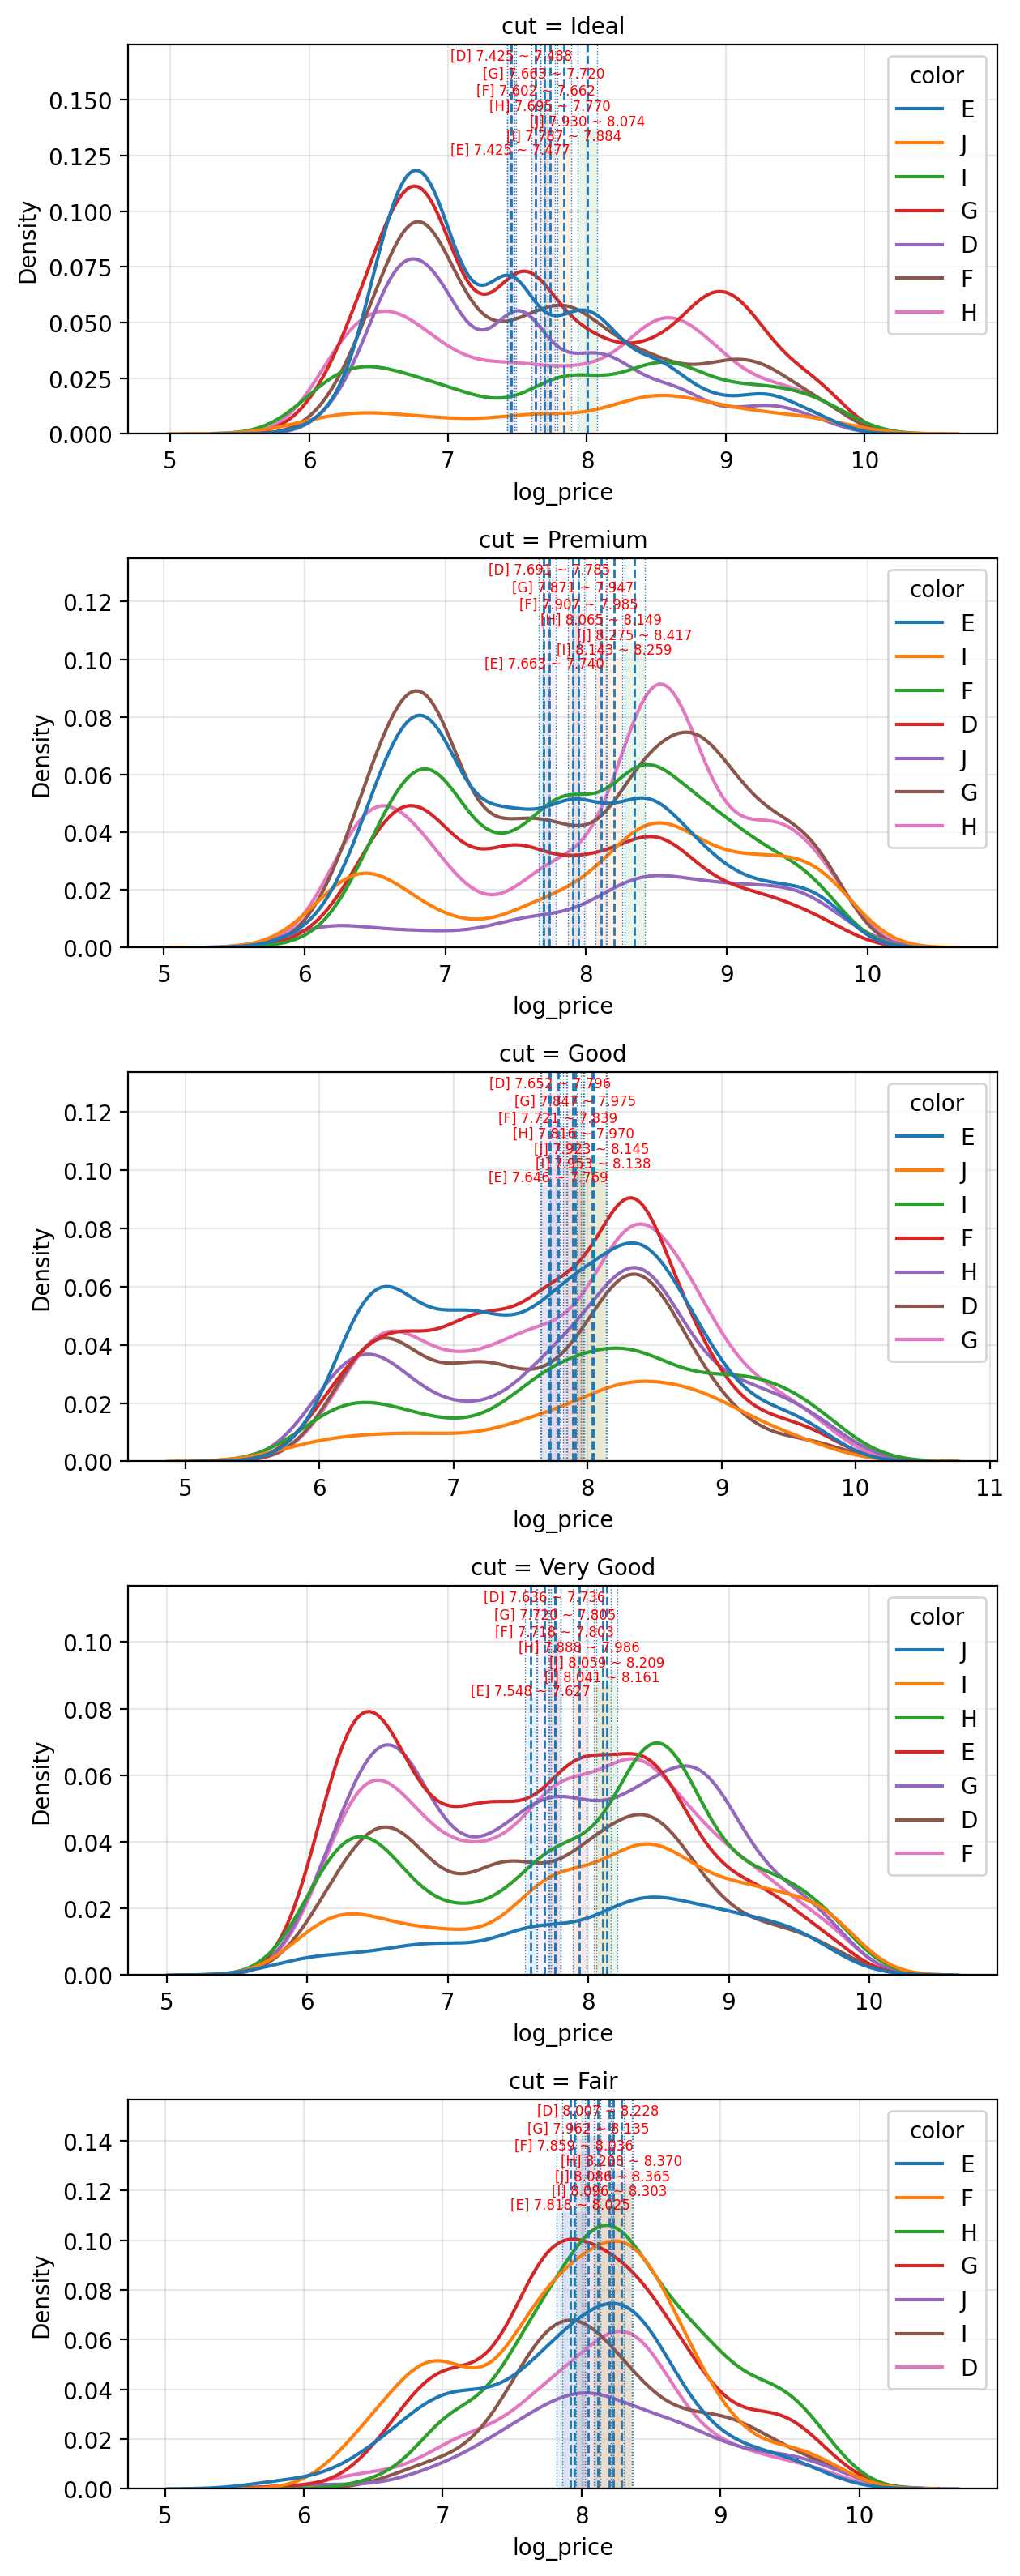

In [247]:
field = "log_price"
group_field = "cut"
hue_field = "color"


data = df2[[field, group_field, hue_field]].dropna().copy()

group_values = data[group_field].unique()
group_count = len(group_values)
hue_values = data[hue_field].unique()

# 1) 그래프 초기화
rows = group_count
cols = 1
width_px = 1280 * cols
height_px = 640 * rows
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)


# 2) 그래프 그리기
for i, v in enumerate(group_values):
    temp = data[data[group_field] == v]

    # KDE Plot
    sb.kdeplot(data=temp, x=field, hue=hue_field, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title("{0} = {1}".format(group_field, v), fontsize=10, pad=5)

    for h in hue_values:
        temp_sub = temp[temp[hue_field] == h]
        n = len(temp_sub[field])

        # 표본이 너무 적으면 신뢰구간 계산 불가 → 스킵
        if n < 2:
            continue

        clevel = 0.95
        dof = n - 1
        sp_mean = temp_sub[field].mean()
        sp_std = temp_sub[field].std(ddof=1)
        sp_std_error = sp_std / sqrt(n)

        # 표준오차가 0/NaN이면 스킵
        if not (sp_std_error > 0):
            continue

        cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

        # 신뢰구간 경계선
        ax[i].axvline(cmin, linestyle=":", linewidth=0.5)
        ax[i].axvline(cmax, linestyle=":", linewidth=0.5)

        # 평균 및 신뢰구간 영역 표시
        ymin, ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle="--", linewidth=1)

        # 텍스트
        ax[i].text(
            x=(cmax - cmin) / 2 + cmin,
            y=ymax,
            s="[%s] %0.3f ~ %0.3f" % (h, cmin, cmax),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 6, "color": "red"},
        )

# 4) 출력
plt.tight_layout()
plt.show()
plt.close()

In [248]:
data = df7.copy()

xname = ["cut", "color"]
yname = "log_price"

u1 = data[xname[0]].unique()
u2 = data[xname[1]].unique()

equal_var_fields = []
normal_dist = True
report = []

for i in u1:
    for j in u2:
        filtered = data[(data[xname[0]] == i) & (data[xname[1]] == j)][yname].dropna()
        if len(filtered) == 0:
            continue

        equal_var_fields.append(filtered)

        s, p = normaltest(filtered)
        normalize = p > 0.05

        report.append(
            {
                "field": "{0}={1}, {2}={3}".format(xname[0], i, xname[1], j),
                "statistic": s,
                "p-value": p,
                "result": normalize,
            }
        )

        normal_dist = normal_dist and normalize

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*equal_var_fields)
else:
    n = "Levene"
    s, p = levene(*equal_var_fields, center="median")

equal_var = p > 0.05

report.append({"field": n, "statistic": s, "p-value": p, "result": equal_var})

report_df = DataFrame(report).set_index("field")
report_df

,statistic,p-value,result
field,,,
"cut=Ideal, color=E",310.449469,3.861485e-68,False
"cut=Ideal, color=I",2720.495708,0.000000e+00,False
"cut=Ideal, color=J",258.512577,7.323307e-57,False
"cut=Ideal, color=H",4463.144354,0.000000e+00,False
"cut=Ideal, color=F",526.215760,5.416261e-115,False
"cut=Ideal, color=G",2433.024869,0.000000e+00,False
"cut=Ideal, color=D",213.568495,4.209113e-47,False
"cut=Premium, color=E",358.024223,1.803133e-78,False
"cut=Premium, color=I",305.335780,4.979410e-67,False


In [249]:
xname = ["cut", "color"]
yname = "log_price"
data = df7[xname + [yname]]

pg_anova = anova(data=data, dv=yname, between=xname, detailed=True)
display(pg_anova)

for idx in pg_anova.index:
    row = pg_anova.iloc[idx]
    source = row["Source"]
    p_val = row["p-unc"]

    if p_val <= 0.05:
        print(f"→ {source} 효과는 유의함. (대립가설 채택: p ≤ 0.05)")
    else:
        print(f"→ {source} 효과는 유의하지 않음. (귀무가설 채택: p > 0.05)")

,Source,SS,DF,MS,F,p-unc,np2
0,cut,898.699723,4.0,224.674931,228.100534,1.534256e-194,0.016650
1,color,1324.122097,6.0,220.687016,224.051816,1.005285e-283,0.024341
2,cut * color,95.012737,24.0,3.958864,4.019225,1.228913e-10,0.001787
3,Residual,53075.757557,53885.0,0.984982,NaN,NaN,NaN


→ cut 효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ color 효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ cut * color 효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ Residual 효과는 유의하지 않음. (귀무가설 채택: p > 0.05)


In [250]:
xname = ["cut", "color"]
yname = "log_price"

data = df7[xname + [yname]]

levels = {}  # 빈 딕셔너리 만들기
# 예: {'water': 2, 'sun': 3} 이런 식 결과
for factor in xname:  # 요인을 하나씩 꺼냄
    level_count = data[factor].nunique()  # 요인의 수준 수 계산
    levels[factor] = level_count  # 딕셔너리에 저장

pvals = {}  # 빈 딕셔너리 만들기
# 예: {'water': 1.30e-20, 'sun': 2.01e-17, 'water * sun': 0.105}
for index, row in pg_anova.iterrows():  # 행을 하나씩 꺼냄
    source_name = row["Source"]  # 요인 이름
    p_value = row["p-unc"]  # 각 요인의 p-value
    pvals[source_name] = p_value  # 딕셔너리에 저장

# 주효과 사후검정
for factor in xname:
    print(f"\n[{factor}]")

    # 수준이 2개면 사후검정 필요 없음
    if levels[factor] == 2:
        print(f"- {levels[factor]}수준 요인이므로 사후검정이 필요 없습니다.")
        continue

    p_val = pvals.get(factor, None)
    if p_val is None:
        print("- ANOVA 결과에서 해당 요인을 찾을 수 없습니다.")
        continue

    if p_val > 0.05:
        print(f"- 주효과 유의하지 않음 (p={p_val:.3g}) → 사후검정 수행 안 함")
        continue

    print(f"- 주효과 유의 (p={p_val:.3g}) → 사후검정 수행")

    if equal_var:
        print(" · Tukey HSD 사용 (등분산 충족)")
        hoc_df = pairwise_tukey(data=data, dv=yname, between=factor)
    else:
        print(" · Games–Howell 사용 (등분산 불충족)")
        hoc_df = pairwise_gameshowell(data=data, dv=yname, between=factor)

    display(hoc_df)

# 상호작용 자동 처리
interaction_names = [src for src in pvals.keys() if "*" in src]

for inter in interaction_names:
    p_val = pvals[inter]
    print(f"\n[{inter}] 상호작용 효과")

    if p_val <= 0.05:
        print(f"- 상호작용 유의 (p={p_val:.3g}) → 단순주효과 분석 필요")
    else:
        print(f"- 상호작용 유의하지 않음 (p={p_val:.3g}) → 단순주효과 분석 필요 없음")


[cut]
- 주효과 유의 (p=1.53e-194) → 사후검정 수행
 · Games–Howell 사용 (등분산 불충족)


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Fair,Good,8.093026,7.842348,0.250678,0.023695,10.579464,3475.310280,3.799183e-13,0.268669
1,Fair,Ideal,8.093026,7.639297,0.453730,0.020264,22.390859,2033.505656,0.000000e+00,0.463793
2,Fair,Premium,8.093026,7.949996,0.143031,0.021022,6.803992,2345.633811,1.283564e-10,0.142233
3,Fair,Very Good,8.093026,7.798602,0.294424,0.021308,13.817769,2469.220433,0.000000e+00,0.291692
4,Good,Ideal,7.842348,7.639297,0.203051,0.015563,13.047300,7354.842443,0.000000e+00,0.205039
5,Good,Premium,7.842348,7.949996,-0.107647,0.016537,-6.509481,9001.061783,7.912575e-10,-0.105803
6,Good,Very Good,7.842348,7.798602,0.043746,0.016899,2.588657,9554.903552,7.249838e-02,0.042821
7,Ideal,Premium,7.639297,7.949996,-0.310699,0.011075,-28.053299,28558.962586,0.000000e+00,-0.308500
8,Ideal,Very Good,7.639297,7.798602,-0.159305,0.011609,-13.722405,24097.017625,0.000000e+00,-0.157926
9,Premium,Very Good,7.949996,7.798602,0.151394,0.012886,11.748769,25369.320809,1.272171e-11,0.146499



[color]
- 주효과 유의 (p=1.01e-283) → 사후검정 수행
 · Games–Howell 사용 (등분산 불충족)


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,D,E,7.616603,7.579405,0.037199,0.014630,2.542700,14556.543791,1.442705e-01,0.040183
1,D,F,7.616603,7.762331,-0.145727,0.014993,-9.719835,14960.777520,0.000000e+00,-0.153289
2,D,G,7.616603,7.788974,-0.172371,0.014839,-11.615888,15427.251815,0.000000e+00,-0.173966
3,D,H,7.616603,7.917493,-0.300890,0.016209,-18.562688,15006.198965,0.000000e+00,-0.299767
4,D,I,7.616603,8.022663,-0.406060,0.018766,-21.638619,10552.203050,4.980460e-12,-0.402056
5,D,J,7.616603,8.145970,-0.529367,0.022593,-23.430733,4750.050236,3.315126e-13,-0.551216
6,E,F,7.579405,7.762331,-0.182926,0.013623,-13.427614,19234.992652,4.439005e-12,-0.193258
7,E,G,7.579405,7.788974,-0.209570,0.013454,-15.576802,21050.962689,1.998401e-14,-0.213516
8,E,H,7.579405,7.917493,-0.338089,0.014952,-22.612206,16582.336147,8.474887e-12,-0.341210
9,E,I,7.579405,8.022663,-0.443259,0.017690,-25.056439,9634.838335,0.000000e+00,-0.446179



[cut * color] 상호작용 효과
- 상호작용 유의 (p=1.23e-10) → 단순주효과 분석 필요


In [251]:
df8 = df2[["cut", "clarity", "log_price"]].copy()
df8

,cut,clarity,log_price
0,Ideal,SI2,5.786897
1,Premium,SI1,5.786897
2,Good,VS1,5.789960
3,Premium,VS2,5.811141
4,Good,SI2,5.814131
...,...,...,...
53935,Ideal,SI1,7.921898
53936,Good,SI1,7.921898
53937,Very Good,SI1,7.921898
53938,Premium,SI2,7.921898


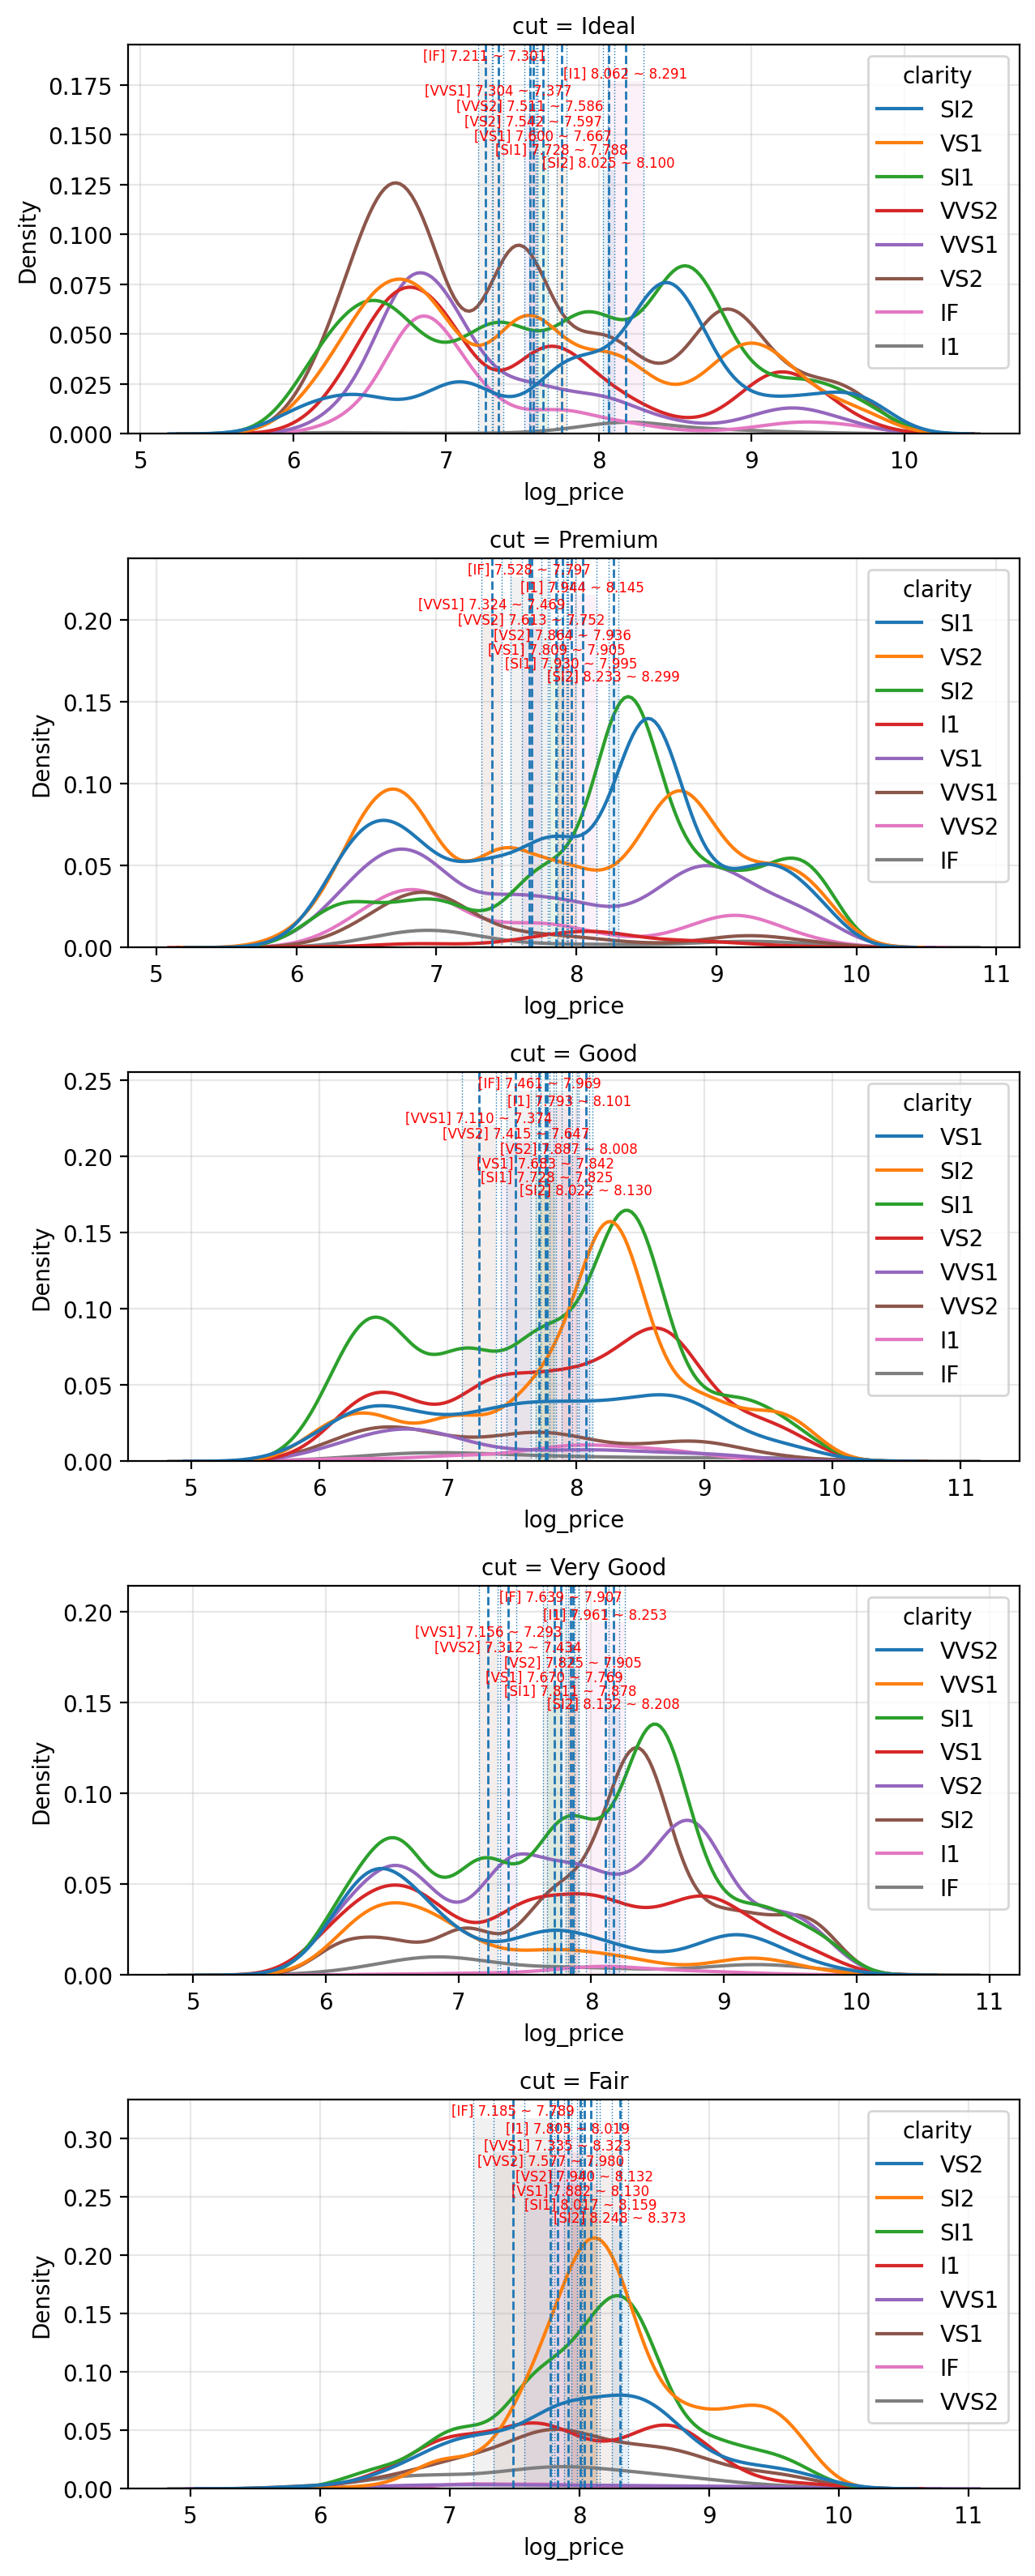

In [252]:
field = "log_price"
group_field = "cut"
hue_field = "clarity"


data = df2[[field, group_field, hue_field]].dropna().copy()

group_values = data[group_field].unique()
group_count = len(group_values)
hue_values = data[hue_field].unique()

# 1) 그래프 초기화
rows = group_count
cols = 1
width_px = 1280 * cols
height_px = 640 * rows
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)


# 2) 그래프 그리기
for i, v in enumerate(group_values):
    temp = data[data[group_field] == v]

    # KDE Plot
    sb.kdeplot(data=temp, x=field, hue=hue_field, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title("{0} = {1}".format(group_field, v), fontsize=10, pad=5)

    for h in hue_values:
        temp_sub = temp[temp[hue_field] == h]
        n = len(temp_sub[field])

        # 표본이 너무 적으면 신뢰구간 계산 불가 → 스킵
        if n < 2:
            continue

        clevel = 0.95
        dof = n - 1
        sp_mean = temp_sub[field].mean()
        sp_std = temp_sub[field].std(ddof=1)
        sp_std_error = sp_std / sqrt(n)

        if not (sp_std_error > 0):
            continue

        cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

        # 신뢰구간 경계선
        ax[i].axvline(cmin, linestyle=":", linewidth=0.5)
        ax[i].axvline(cmax, linestyle=":", linewidth=0.5)

        # 평균 및 신뢰구간 영역 표시
        ymin, ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle="--", linewidth=1)

        # 텍스트
        ax[i].text(
            x=(cmax - cmin) / 2 + cmin,
            y=ymax,
            s="[%s] %0.3f ~ %0.3f" % (h, cmin, cmax),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 6, "color": "red"},
        )

# 4) 출력
plt.tight_layout()
plt.show()
plt.close()

In [253]:
xname = ["cut", "clarity"]
yname = "log_price"
data = df8[xname + [yname]]

pg_anova = anova(data=data, dv=yname, between=xname, detailed=True)
display(pg_anova)

for idx in pg_anova.index:
    row = pg_anova.iloc[idx]
    source = row["Source"]
    p_val = row["p-unc"]

    if p_val <= 0.05:
        print(f"→ {source} 효과는 유의함. (대립가설 채택: p ≤ 0.05)")
    else:
        print(f"→ {source} 효과는 유의하지 않음. (귀무가설 채택: p > 0.05)")

,Source,SS,DF,MS,F,p-unc,np2
0,cut,465.599616,4.0,116.399904,120.842091,7.710683e-103,0.008891
1,clarity,2296.175982,7.0,328.025140,340.543614,0.000000e+00,0.042368
2,cut * clarity,299.359587,28.0,10.691414,11.099432,2.564097e-49,0.005735
3,Residual,51899.356822,53880.0,0.963240,NaN,NaN,NaN


→ cut 효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ clarity 효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ cut * clarity 효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ Residual 효과는 유의하지 않음. (귀무가설 채택: p > 0.05)


In [254]:
xname = ["cut", "clarity"]
yname = "log_price"

data = df8[xname + [yname]]

levels = {}  # 빈 딕셔너리 만들기
# 예: {'water': 2, 'sun': 3} 이런 식 결과
for factor in xname:  # 요인을 하나씩 꺼냄
    level_count = data[factor].nunique()  # 요인의 수준 수 계산
    levels[factor] = level_count  # 딕셔너리에 저장

pvals = {}  # 빈 딕셔너리 만들기
# 예: {'water': 1.30e-20, 'sun': 2.01e-17, 'water * sun': 0.105}
for index, row in pg_anova.iterrows():  # 행을 하나씩 꺼냄
    source_name = row["Source"]  # 요인 이름
    p_value = row["p-unc"]  # 각 요인의 p-value
    pvals[source_name] = p_value  # 딕셔너리에 저장

# 주효과 사후검정
for factor in xname:
    print(f"\n[{factor}]")

    # 수준이 2개면 사후검정 필요 없음
    if levels[factor] == 2:
        print(f"- {levels[factor]}수준 요인이므로 사후검정이 필요 없습니다.")
        continue

    p_val = pvals.get(factor, None)
    if p_val is None:
        print("- ANOVA 결과에서 해당 요인을 찾을 수 없습니다.")
        continue

    if p_val > 0.05:
        print(f"- 주효과 유의하지 않음 (p={p_val:.3g}) → 사후검정 수행 안 함")
        continue

    print(f"- 주효과 유의 (p={p_val:.3g}) → 사후검정 수행")

    if equal_var:
        print(" · Tukey HSD 사용 (등분산 충족)")
        hoc_df = pairwise_tukey(data=data, dv=yname, between=factor)
    else:
        print(" · Games–Howell 사용 (등분산 불충족)")
        hoc_df = pairwise_gameshowell(data=data, dv=yname, between=factor)

    display(hoc_df)

# 상호작용 자동 처리
interaction_names = [src for src in pvals.keys() if "*" in src]

for inter in interaction_names:
    p_val = pvals[inter]
    print(f"\n[{inter}] 상호작용 효과")

    if p_val <= 0.05:
        print(f"- 상호작용 유의 (p={p_val:.3g}) → 단순주효과 분석 필요")
    else:
        print(f"- 상호작용 유의하지 않음 (p={p_val:.3g}) → 단순주효과 분석 필요 없음")


[cut]
- 주효과 유의 (p=7.71e-103) → 사후검정 수행
 · Games–Howell 사용 (등분산 불충족)


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Fair,Good,8.093026,7.842348,0.250678,0.023695,10.579464,3475.310280,3.799183e-13,0.268669
1,Fair,Ideal,8.093026,7.639297,0.453730,0.020264,22.390859,2033.505656,0.000000e+00,0.463793
2,Fair,Premium,8.093026,7.949996,0.143031,0.021022,6.803992,2345.633811,1.283564e-10,0.142233
3,Fair,Very Good,8.093026,7.798602,0.294424,0.021308,13.817769,2469.220433,0.000000e+00,0.291692
4,Good,Ideal,7.842348,7.639297,0.203051,0.015563,13.047300,7354.842443,0.000000e+00,0.205039
5,Good,Premium,7.842348,7.949996,-0.107647,0.016537,-6.509481,9001.061783,7.912575e-10,-0.105803
6,Good,Very Good,7.842348,7.798602,0.043746,0.016899,2.588657,9554.903552,7.249838e-02,0.042821
7,Ideal,Premium,7.639297,7.949996,-0.310699,0.011075,-28.053299,28558.962586,0.000000e+00,-0.308500
8,Ideal,Very Good,7.639297,7.798602,-0.159305,0.011609,-13.722405,24097.017625,0.000000e+00,-0.157926
9,Premium,Very Good,7.949996,7.798602,0.151394,0.012886,11.748769,25369.320809,1.272171e-11,0.146499



[clarity]
- 주효과 유의 (p=0) → 사후검정 수행
 · Games–Howell 사용 (등분산 불충족)


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,I1,IF,8.027355,7.405190,0.622165,0.034921,17.816108,1685.065183,0.000000e+00,0.713736
1,I1,SI1,8.027355,7.847698,0.179657,0.028676,6.265097,891.560216,1.618550e-08,0.183797
2,I1,SI2,8.027355,8.166375,-0.139020,0.028966,-4.799401,927.616647,5.055519e-05,-0.153519
3,I1,VS1,8.027355,7.724646,0.302709,0.029687,10.196695,1021.725399,7.422951e-13,0.295533
4,I1,VS2,8.027355,7.762590,0.264765,0.028888,9.165196,918.010526,0.000000e+00,0.259862
5,I1,VVS1,8.027355,7.322330,0.705025,0.031076,22.687377,1209.480262,0.000000e+00,0.810581
6,I1,VVS2,8.027355,7.530843,0.496512,0.030897,16.070059,1188.903307,2.120526e-14,0.499883
7,IF,SI1,7.405190,7.847698,-0.442507,0.023387,-18.920961,2393.287329,7.117640e-13,-0.451114
8,IF,SI2,7.405190,8.166375,-0.761185,0.023742,-32.060497,2532.128234,0.000000e+00,-0.829466
9,IF,VS1,7.405190,7.724646,-0.319456,0.024616,-12.977379,2896.623483,0.000000e+00,-0.311861



[cut * clarity] 상호작용 효과
- 상호작용 유의 (p=2.56e-49) → 단순주효과 분석 필요


In [255]:
df8 = df2.filter(["log_price", "log_carat", "x", "y", "z", "depth", "table"])
df8

,log_price,log_carat,x,y,z,depth,table
0,5.786897,-1.469676,3.95,3.98,2.43,61.5,55.0
1,5.786897,-1.560648,3.89,3.84,2.31,59.8,61.0
2,5.789960,-1.469676,4.05,4.07,2.31,56.9,65.0
3,5.811141,-1.237874,4.20,4.23,2.63,62.4,58.0
4,5.814131,-1.171183,4.34,4.35,2.75,63.3,58.0
...,...,...,...,...,...,...,...
53935,7.921898,-0.328504,5.75,5.76,3.50,60.8,57.0
53936,7.921898,-0.328504,5.69,5.75,3.61,63.1,55.0
53937,7.921898,-0.356675,5.66,5.68,3.56,62.8,60.0
53938,7.921898,-0.150823,6.15,6.12,3.74,61.0,58.0


In [256]:
skew_outlier = {}
for col in df8.columns:
    temp = df8[col].dropna()
    skew_original = temp.skew()
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))
    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()
    skew_outlier[col] = {
        "original_skew": skew_original,
        "log_skew": skew_log,
        "outliers(|z|>3)": outlier_count,
    }
skew_outlier_df = DataFrame(skew_outlier).T
skew_outlier_df

,original_skew,log_skew,outliers(|z|>3)
log_price,0.115461,-0.226106,0.0
log_carat,0.096266,-0.144601,6.0
x,0.398348,-0.012942,35.0
y,2.462211,0.015552,27.0
z,1.585490,0.195391,36.0
depth,-0.081726,-2.177476,685.0
table,0.796799,0.159840,335.0


In [257]:
rows = []

for a, b in combinations(df8.columns, 2):
    x = df8[a]
    y = df8[b]

    # [1] 선형성 확인 (Ramsey RESET)
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    reset = linear_reset(model, power=2, use_f=True)
    linearity_ok = reset.pvalue > 0.05

    # [2] 이상치 존재 여부(|z|>3 기준)
    a_flag = skew_outlier_df.loc[a, "outliers(|z|>3)"] > 0
    b_flag = skew_outlier_df.loc[b, "outliers(|z|>3)"] > 0
    outlier_flag = a_flag or b_flag

    # [3] 상관계수 선택 및 계산
    if linearity_ok and not outlier_flag:
        chosen = "pearson"
        corr, pval = pearsonr(x, y)
    else:
        chosen = "spearman"
        corr, pval = spearmanr(x, y)

    # [4] 유의성 판단 (p <= 0.05)
    significant = pval <= 0.05

    # [5] 상관 강도 계산
    abs_r = abs(corr)
    if abs_r >= 0.80:
        strength = "Very strong"
    elif abs_r >= 0.60:
        strength = "Strong"
    elif abs_r >= 0.40:
        strength = "Medium"
    elif abs_r >= 0.20:
        strength = "Weak"
    else:
        strength = "Very weak"

    # [6] 행 추가
    rows.append(
        {
            "var_a": a,
            "var_b": b,
            "linearity": linearity_ok,
            "outlier_flag": outlier_flag,
            "chosen": chosen,
            "corr": corr,
            "pval": pval,
            "significant": significant,
            "strength": strength,
        }
    )

summary_df = DataFrame(rows)
summary_df

,var_a,var_b,linearity,outlier_flag,chosen,corr,pval,significant,strength
0,log_price,log_carat,False,True,spearman,0.962888,0.000000e+00,True,Very strong
1,log_price,x,False,True,spearman,0.963754,0.000000e+00,True,Very strong
2,log_price,y,False,True,spearman,0.963215,0.000000e+00,True,Very strong
3,log_price,z,False,True,spearman,0.958593,0.000000e+00,True,Very strong
4,log_price,depth,False,True,spearman,0.010013,2.006221e-02,True,Very weak
5,log_price,table,False,True,spearman,0.171797,0.000000e+00,True,Very weak
6,log_carat,x,False,True,spearman,0.996645,0.000000e+00,True,Very strong
7,log_carat,y,False,True,spearman,0.996033,0.000000e+00,True,Very strong
8,log_carat,z,False,True,spearman,0.994708,0.000000e+00,True,Very strong
9,log_carat,depth,True,True,spearman,0.030146,2.529887e-12,True,Very weak


In [258]:
# 1) 등장하는 모든 변수 목록 추출
vars = sorted(set(summary_df["var_a"]).union(summary_df["var_b"]))
# 2) 빈 상관행렬 생성 (NaN으로 초기화)
corr_matrix = DataFrame(np.nan, index=vars, columns=vars)
# 3) summary_df 내용을 반영하여 대칭 행렬 채우기
for _, row in summary_df.iterrows():
    a, b, r = row["var_a"], row["var_b"], row["corr"]
    corr_matrix.loc[a, b] = r
    corr_matrix.loc[b, a] = r  # 대칭
# 4) 대각선(diagonal)을 1로 설정
np.fill_diagonal(corr_matrix.values, 1)
corr_matrix

,depth,log_carat,log_price,table,x,y,z
depth,1.000000,0.030146,0.010013,-0.245098,-0.023214,-0.025186,0.103568
log_carat,0.030146,1.000000,0.962888,0.194941,0.996645,0.996033,0.994708
log_price,0.010013,0.962888,1.000000,0.171797,0.963754,0.963215,0.958593
table,-0.245098,0.194941,0.171797,1.000000,0.202294,0.195833,0.160294
x,-0.023214,0.996645,0.963754,0.202294,1.000000,0.997961,0.988378
y,-0.025186,0.996033,0.963215,0.195833,0.997961,1.000000,0.988141
z,0.103568,0.994708,0.958593,0.160294,0.988378,0.988141,1.000000


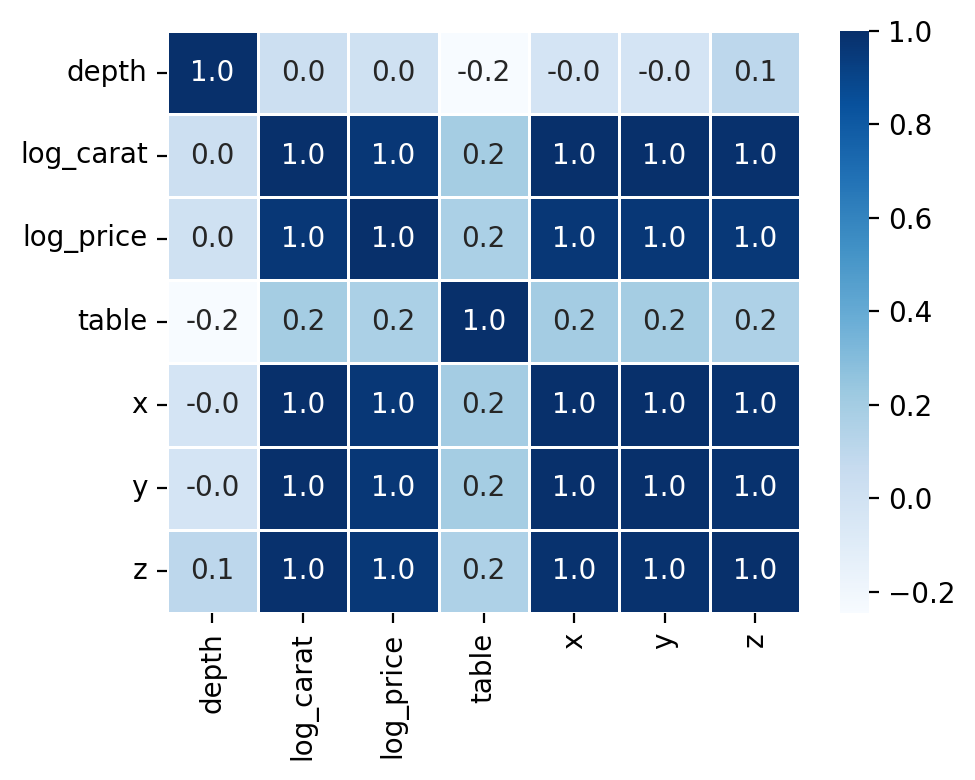

In [259]:
# 1) 그래프 초기화
width_px = 1000  # 그래프 가로 크기
height_px = 800  # 그래프 세로 크기
rows = 1  # 그래프 행 수
cols = 1  # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
# 2) heatmap 그리기
sb.heatmap(
    data=corr_matrix,
    annot=True,
    fmt="0.1f",
    linewidth=0.5,
    cmap="Blues",
    annot_kws={"size": 10},
)
# 4) 출력
plt.tight_layout()  # 여백 제거
plt.show()  # 그래프 화면 출력
plt.close()  # 그래프 작업 종료

In [260]:
df10 = df2.filter(
    ["price", "carat", "depth", "table", "x", "y", "z", "cut", "color", "clarity"]
).copy()

df10.head()

df10 = get_dummies(
    df10, columns=["cut", "color", "clarity"], dtype="int", drop_first=True
)
df10.head()

,price,carat,depth,table,x,y,z,cut_Good,cut_Ideal,cut_Premium,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,326,0.23,61.5,55.0,3.95,3.98,2.43,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,326,0.21,59.8,61.0,3.89,3.84,2.31,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,327,0.23,56.9,65.0,4.05,4.07,2.31,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,334,0.29,62.4,58.0,4.20,4.23,2.63,0,0,1,...,0,1,0,0,0,0,0,1,0,0
4,335,0.31,63.3,58.0,4.34,4.35,2.75,1,0,0,...,0,0,1,0,0,1,0,0,0,0


In [261]:
yname = "price"

x = df10.drop(yname, axis=1)
y = df10[yname]

x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
print(tbl1)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                 2.699e+04
Date:                Tue, 13 Jan 2026   Prob (F-statistic):               0.00
Time:                        15:03:34   Log-Likelihood:            -4.5542e+05
No. Observations:               53920   AIC:                         9.109e+05
Df Residuals:                   53896   BIC:                         9.111e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2711.9832    413.798      6.554

In [262]:
def ols_report(tbl, data):
    """
    OLS summary(tbl)와 데이터프레임(data)을 받아 회귀계수 표(rdf),
    모델 적합도 요약(result_report), 모형 보고 문장(model_report),
    변수별 보고 리스트(variable_reports)를 반환한다.

    Parameters
    ----------
    tbl : statsmodels.iolib.summary.Summary
        sm.OLS(...).fit().summary() 결과로 생성된 summary 객체.
    data : pandas.DataFrame
        종속변수와 독립변수를 모두 포함한 데이터프레임.

    Returns
    -------
    tuple
        (회귀계수 DataFrame, 적합도 요약 문자열, 모형 보고 문자열, 변수별 보고 리스트)
    """

    # 독립변수 이름(상수항 제외)
    xnames = [n for n in fit.model.exog_names if n != "const"]

    # 독립변수 부분 데이터 (VIF 계산용)
    indi_df = data.filter(xnames)

    # 독립변수 결과를 누적
    variables = []

    for i, v in enumerate(tbl.tables[1].data):
        # 한 행의 변수명 추출 후 목록에 있는지 확인
        name = v[0].strip()
        if name not in xnames:
            continue

        # VIF 계산을 위해 열 인덱스 조회
        j = list(indi_df.columns).index(name)
        vif = variance_inflation_factor(indi_df, j)

        # 유의확률과 별표 표시 함수
        p = float(v[4].strip())

        def stars(p):
            return "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""

        # 한 변수에 대한 보고 정보 추가
        variables.append(
            {
                "종속변수": yname,  # 종속변수 이름 (외부에서 정의)
                "독립변수": name,  # 독립변수 이름
                "B": v[1].strip(),  # 비표준화 회귀계수(B)
                "표준오차": v[2].strip(),  # 계수 표준오차
                "Beta": float(fit.params[name])
                * (
                    data[name].std(ddof=1) / data[yname].std(ddof=1)
                ),  # 표준화 회귀계수(β)
                "t": "%s%s" % (v[3].strip(), stars(p)),  # t-통계량(+별표)
                "p-value": p,  # 계수 유의확률
                "공차": 1 / vif,  # 공차(Tolerance = 1/VIF)
                "vif": vif,  # 분산팽창계수
            }
        )

    rdf = DataFrame(variables)

    # summary 표에서 적합도 정보를 key-value로 추출
    result_dict = {}
    for idx in [0, 2]:
        for item in tbl.tables[idx].data:
            n = len(item)
            for j in range(0, n, 2):
                key = item[j].strip()[:-1]
                value = item[j + 1].strip()
                if not key or not value:
                    continue
                result_dict[key] = value

    # 적합도 보고 문자열 구성
    result_report = (
        f"𝑅({result_dict['R-squared']}), "
        f"𝑅^2({result_dict['Adj. R-squared']}), "
        f"𝐹({result_dict['F-statistic']}), "
        f"유의확률({result_dict['Prob (F-statistic)']}), "
        f"Durbin-Watson({result_dict['Durbin-Watson']})"
    )

    # 모형 보고 문장 구성
    p_f = float(result_dict["Prob (F-statistic)"])
    sig_text = "유의하다" if p_f <= 0.05 else "유의하지 않다"
    p_sign = "≤" if p_f <= 0.05 else ">"

    tpl = (
        "%s에 대하여 %s로 예측하는 회귀분석을 실시한 결과, "
        "이 회귀모형은 통계적으로 %s(F(%s,%s) = %s, p %s 0.05)."
    )

    model_report = tpl % (
        rdf["종속변수"][0],
        ",".join(list(rdf["독립변수"])),
        sig_text,
        result_dict["Df Model"],
        result_dict["Df Residuals"],
        result_dict["F-statistic"],
        p_sign,
    )

    # 변수별 보고 문장 리스트 구성
    variable_reports = []
    s = "%s의 회귀계수는 %s(p %s 0.05)로, %s에 대하여 %s 예측변인인 것으로 나타났다."

    for i in rdf.index:
        row = rdf.iloc[i]
        p_val = float(row["p-value"])
        p_sign_var = "≤" if p_val < 0.05 else ">"
        sig_word = "유의미한" if p_val < 0.05 else "유의하지 않은"

        variable_reports.append(
            s
            % (
                row["독립변수"],
                row["B"],
                p_sign_var,
                row["종속변수"],
                sig_word,
            )
        )

    return rdf, result_report, model_report, variable_reports

In [263]:
rdf, r, m, v = ols_report(tbl1, df10)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,1.153e+04,51.630,1.369557,223.235***,0.000,0.011638,85.923388
1,price,depth,-65.0768,4.639,-0.023377,-14.029***,0.000,0.001467,681.712859
2,price,table,-26.4441,2.905,-0.014817,-9.102***,0.000,0.001511,661.714532
3,price,x,-1100.6815,34.993,-0.309015,-31.455***,0.000,0.000662,1510.229521
4,price,y,25.9330,19.447,0.007415,1.334,0.182,0.001833,545.507278
5,price,z,-114.9809,37.840,-0.020259,-3.039**,0.002,0.001402,713.361665
6,price,cut_Good,574.3906,33.526,0.041414,17.132***,0.000,0.242559,4.122713
7,price,cut_Ideal,824.8785,33.339,0.101334,24.742***,0.000,0.065659,15.230171
8,price,cut_Premium,753.0040,32.164,0.082374,23.411***,0.000,0.100353,9.964785
9,price,cut_Very Good,717.3414,32.178,0.075015,22.293***,0.000,0.114119,8.762759


price에 대하여 carat,depth,table,x,y,z,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(23,53896) = 2.699e+04, p ≤ 0.05).


In [264]:
df11 = df10.drop("x", axis=1)
yname = "price"
x = df11.drop(yname, axis=1)
y = df11[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl2 = fit.summary()
rdf, r, m, v = ols_report(tbl2, df11)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,1.058e+04,42.329,1.257042,249.919***,0.000,0.015960,62.657396
1,price,depth,-9.3192,4.326,-0.003348,-2.154*,0.031,0.001479,675.995467
2,price,table,-27.4532,2.932,-0.015382,-9.364***,0.000,0.001776,563.098469
3,price,y,-245.5736,17.585,-0.070220,-13.965***,0.000,0.002491,401.518239
4,price,z,-792.1348,31.403,-0.139568,-25.225***,0.000,0.001898,526.807088
5,price,cut_Good,609.2230,33.814,0.043926,18.017***,0.000,0.243379,4.108816
6,price,cut_Ideal,859.0376,33.625,0.105530,25.547***,0.000,0.067467,14.822111
7,price,cut_Premium,771.5286,32.453,0.084400,23.774***,0.000,0.101990,9.804861
8,price,cut_Very Good,768.8592,32.430,0.080402,23.708***,0.000,0.115007,8.695138
9,price,color_E,-206.5591,18.012,-0.019976,-11.468***,0.000,0.407400,2.454592


price에 대하여 carat,depth,table,y,z,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(22,53897) = 2.766e+04, p ≤ 0.05).


In [265]:
df12 = df11.drop("depth", axis=1)
yname = "price"
x = df12.drop(yname, axis=1)
y = df12[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl3 = fit.summary()
rdf, r, m, v = ols_report(tbl3, df12)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,1.058e+04,42.306,1.257406,250.124***,0.0,0.018445,54.215056
1,price,table,-25.0553,2.712,-0.014038,-9.237***,0.0,0.004568,218.921581
2,price,y,-233.3524,16.646,-0.066725,-14.019***,0.0,0.002536,394.322562
3,price,z,-814.5261,29.634,-0.143514,-27.486***,0.0,0.002426,412.197130
4,price,cut_Good,622.3163,33.264,0.044870,18.708***,0.0,0.243812,4.101518
5,price,cut_Ideal,883.6216,31.631,0.108551,27.936***,0.0,0.069156,14.460029
6,price,cut_Premium,793.6248,30.790,0.086817,25.775***,0.0,0.102000,9.803946
7,price,cut_Very Good,787.9554,31.196,0.082399,25.258***,0.0,0.115338,8.670148
8,price,color_E,-206.4775,18.012,-0.019968,-11.463***,0.0,0.408176,2.449922
9,price,color_F,-280.2985,18.212,-0.026824,-15.391***,0.0,0.410158,2.438085


price에 대하여 carat,table,y,z,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(21,53898) = 2.898e+04, p ≤ 0.05).


In [266]:
df13 = df12.drop("table", axis=1)
yname = "price"
x = df13.drop(yname, axis=1)
y = df13[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl4 = fit.summary()
rdf, r, m, v = ols_report(tbl4, df13)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,1.056e+04,42.247,1.254339,249.865***,0.0,0.032893,30.401597
1,price,y,-252.3403,16.531,-0.072154,-15.265***,0.0,0.002836,352.583918
2,price,z,-772.6099,29.308,-0.136128,-26.362***,0.0,0.002885,346.620923
3,price,cut_Good,634.2537,33.265,0.045730,19.067***,0.0,0.253734,3.941137
4,price,cut_Ideal,963.6913,30.444,0.118387,31.655***,0.0,0.070005,14.284650
5,price,cut_Premium,806.5590,30.782,0.088232,26.202***,0.0,0.107645,9.289791
6,price,cut_Very Good,818.9618,31.039,0.085641,26.385***,0.0,0.119195,8.389643
7,price,color_E,-207.8041,18.026,-0.020096,-11.528***,0.0,0.413548,2.418099
8,price,color_F,-279.4165,18.226,-0.026740,-15.330***,0.0,0.413375,2.419111
9,price,color_G,-485.3627,17.844,-0.049518,-27.201***,0.0,0.364368,2.744476


price에 대하여 carat,y,z,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(20,53899) = 3.037e+04, p ≤ 0.05).


In [267]:
df14 = df13.drop("z", axis=1)
yname = "price"
x = df14.drop(yname, axis=1)
y = df14[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl5 = fit.summary()
rdf, r, m, v = ols_report(tbl5, df14)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,9944.1149,35.525,1.181626,279.916***,0.0,0.036351,27.509293
1,price,y,-461.7224,14.591,-0.132025,-31.644***,0.0,0.007018,142.497734
2,price,cut_Good,706.6383,33.365,0.050949,21.179***,0.0,0.254299,3.932381
3,price,cut_Ideal,1057.0546,30.431,0.129856,34.736***,0.0,0.070046,14.276279
4,price,cut_Premium,917.8034,30.687,0.100402,29.908***,0.0,0.107647,9.289585
5,price,cut_Very Good,909.2308,31.048,0.095081,29.285***,0.0,0.119258,8.385182
6,price,color_E,-208.8537,18.141,-0.020198,-11.513***,0.0,0.415948,2.404144
7,price,color_F,-287.7449,18.341,-0.027537,-15.689***,0.0,0.416063,2.403484
8,price,color_G,-495.9512,17.954,-0.050598,-27.624***,0.0,0.367011,2.724714
9,price,color_H,-981.9064,19.091,-0.088863,-51.433***,0.0,0.441907,2.262920


price에 대하여 carat,y,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(19,53900) = 3.153e+04, p ≤ 0.05).


In [268]:
df15 = df14.drop("y", axis=1)
yname = "price"
x = df15.drop(yname, axis=1)
y = df15[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl6 = fit.summary()
rdf, r, m, v = ols_report(tbl6, df15)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,8885.1847,12.036,1.055797,738.242***,0.0,0.214318,4.665954
1,price,cut_Good,656.0893,33.634,0.047305,19.507***,0.0,0.283628,3.525744
2,price,cut_Ideal,998.2289,30.655,0.122630,32.564***,0.0,0.080332,12.448337
3,price,cut_Premium,868.5850,30.931,0.095017,28.081***,0.0,0.121811,8.209455
4,price,cut_Very Good,848.6587,31.275,0.088747,27.136***,0.0,0.135266,7.392822
5,price,color_E,-210.6250,18.309,-0.020369,-11.504***,0.0,0.426671,2.343724
6,price,color_F,-302.0257,18.504,-0.028904,-16.322***,0.0,0.428729,2.332477
7,price,color_G,-504.2469,18.118,-0.051445,-27.832***,0.0,0.376324,2.657281
8,price,color_H,-978.2640,19.267,-0.088533,-50.774***,0.0,0.449739,2.223513
9,price,color_I,-1438.8447,21.639,-0.108517,-66.493***,0.0,0.537616,1.860062


price에 대하여 carat,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(18,53901) = 3.262e+04, p ≤ 0.05).


In [269]:
reset_res = linear_reset(fit, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")
if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 8438.8740
p-value: 0.0000
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


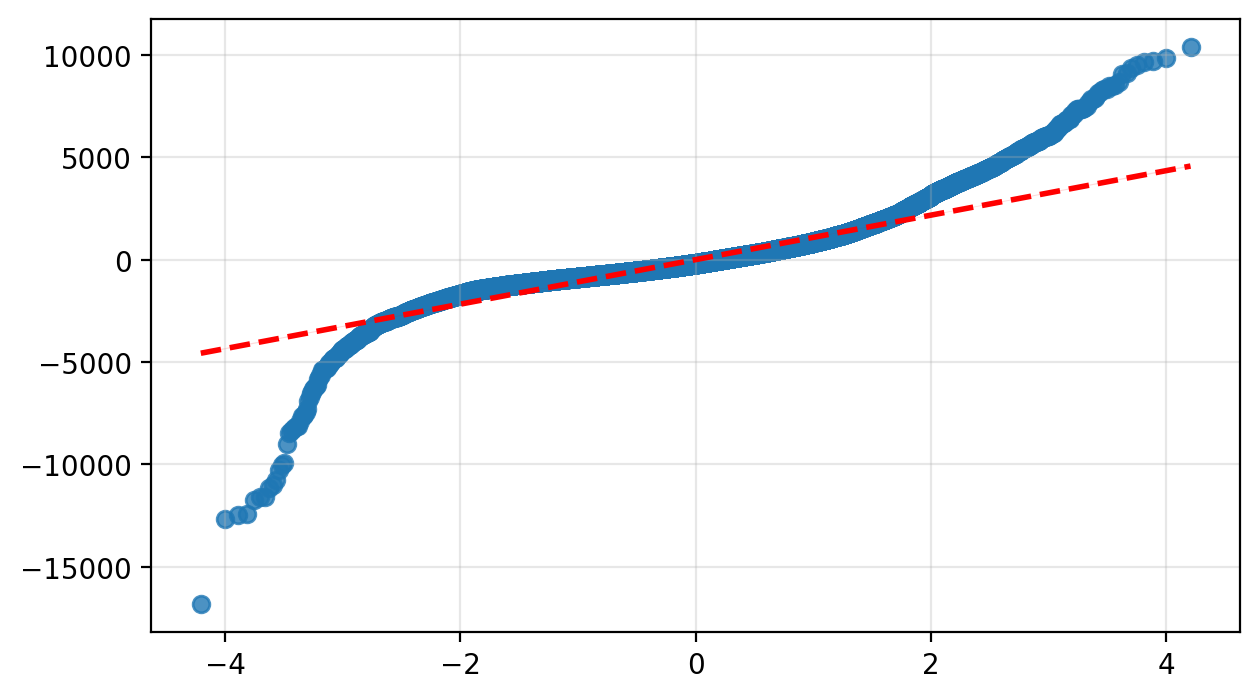

In [270]:
(x, y), _ = probplot(fit.resid)
# 1) 그래프 초기화
width_px = 1280  # 그래프 가로 크기
height_px = 720  # 그래프 세로 크기
rows = 1  # 그래프 행 수
cols = 1  # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
# 2) regplot 그리기
sb.regplot(
    x=x, y=y, line_kws={"color": "red", "linestyle": "--", "linewidth": 2}  # 점선
)
# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3)  # 배경 격자 표시
# 4) 출력
plt.tight_layout()  # 여백 제거
plt.show()  # 그래프 화면 출력
plt.close()  # 그래프 작업 종료

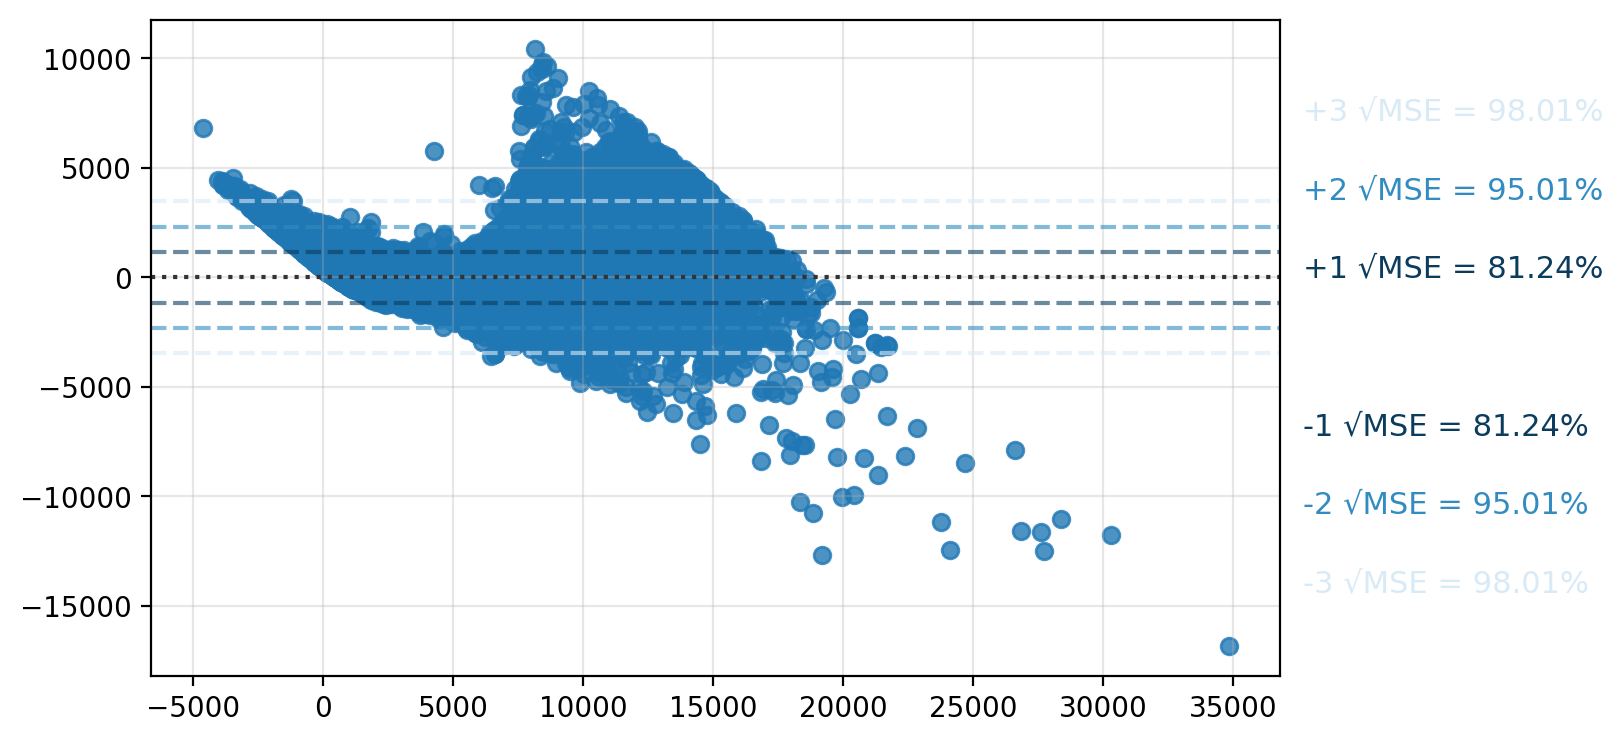

In [271]:
mse_sq = fit.mse_resid
mse_root = np.sqrt(mse_sq)
r = fit.resid  # 잔차

r1 = r[(r > -mse_root) & (r < mse_root)].count() / r.count() * 100
r2 = r[(r > -2 * mse_root) & (r < 2 * mse_root)].count() / r.count() * 100
r3 = r[(r > -3 * mse_root) & (r < 3 * mse_root)].count() / r.count() * 100

mse_r = [r1, r2, r3]

mse_r = [r1, r2, r3]
colors = ["#0B3C5D", "#328CC1", "#D9EAF7"]
xmax = fit.fittedvalues.max()
ymin = fit.fittedvalues.min()
# 1) 그래프 초기화
width_px = 1600
height_px = 720
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi, constrained_layout=True)
# 2) seaborn 기본 잔차도
sb.residplot(x=fit.fittedvalues, y=fit.resid)
# 3) 꾸미기
ax.grid(True, alpha=0.3)
# 4) MSE 3단계 표시
for i, c in enumerate(colors):
    k = i + 1
    # 올바른 ±k√MSE 위치
    y_pos = k * mse_root
    ax.axhline(y=y_pos, color=c, linestyle="--", alpha=0.6)
    ax.axhline(y=-y_pos, color=c, linestyle="--", alpha=0.6)
    # 텍스트는 축 좌표계 사용 (그래프 밖으로 안 나감)
    ax.text(
        x=1.02,
        y=0.5 + 0.12 * k,
        s=f"+{k} √MSE = {mse_r[i]:0.2f}%",
        transform=ax.transAxes,
        ha="left",
        va="center",
        fontsize=11,
        color=c,
    )
    ax.text(
        x=1.02,
        y=0.5 - 0.12 * k,
        s=f"-{k} √MSE = {mse_r[i]:0.2f}%",
        transform=ax.transAxes,
        ha="left",
        va="center",
        fontsize=11,
        color=c,
    )
# 5) 출력
plt.show()
plt.close()

In [272]:
if len(df13) < 5000:
    method = "Shapiro-Wilk"
    stat, p = shapiro(fit.resid)
    print(f"{method} statistic: {stat:.4f}, p-value: {p:.4f}")
    violated = p < 0.05
else:
    method = "Anderson-Darling"
    ad_res = anderson(fit.resid, dist="norm")
    crit_levels = ad_res.significance_level.tolist()
    crit_values = ad_res.critical_values.tolist()
    crit_5 = crit_values[crit_levels.index(5.0)] if 5.0 in crit_levels else None
    print(f"{method} statistic: {ad_res.statistic:.4f}, 5% 임계값: {crit_5:.4f}")
    violated = crit_5 is not None and ad_res.statistic > crit_5
print(
    "정규성 가정 위배 가능성이 있음 (5% 유의수준)"
    if violated
    else "정규성 가정 위배 근거 없음 (5%유의수준)"
)

Anderson-Darling statistic: 1355.5873, 5% 임계값: 0.7870
정규성 가정 위배 가능성이 있음 (5% 유의수준)


In [273]:
# Breusch–Pagan Test
names = ["LM Statistic", "LM p-value", "F Statistic", "F p-value"]
bp_test = het_breuschpagan(fit.resid, fit.model.exog)
bp = DataFrame(bp_test, index=names, columns=["value"])
# p-value는 F p-value를 기준으로 사용
p_bp = bp.loc["F p-value", "value"]
print(
    f"Breusch–Pagan statistic: {bp.loc['F Statistic','value']:.3f}, p-value ={p_bp:.3f}"
)
print(f"{'이분산성 존재(등분산 아님)' if p_bp <= 0.05 else '등분산성 만족'}")

Breusch–Pagan statistic: 582.790, p-value =0.000
이분산성 존재(등분산 아님)


In [274]:
m

'price에 대하여 carat,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(18,53901) = 3.262e+04, p ≤ 0.05).'

In [275]:
print("\n".join(v))

carat의 회귀계수는 8885.1847(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Good의 회귀계수는 656.0893(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Ideal의 회귀계수는 998.2289(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Premium의 회귀계수는 868.5850(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Very Good의 회귀계수는 848.6587(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_E의 회귀계수는 -210.6250(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_F의 회귀계수는 -302.0257(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_G의 회귀계수는 -504.2469(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_H의 회귀계수는 -978.2640(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_I의 회귀계수는 -1438.8447(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_J의 회귀계수는 -2323.7551(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
clarity_IF의 회귀계수는 5418.2607(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
clarity_SI1의 회귀계수는 3572.9344(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
clarity_SI2의 회귀계수는 2626.0346(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
clarity_VS1의 회

In [276]:
origin = pd.read_excel("2사분위수_데이터.xlsx")
dfq2 = origin.drop("Unnamed: 0", axis=1)
dfq2.head()

,price,carat,cut,color,clarity,x,y,z,depth,table
0,949,0.35,Premium,J,VS1,5.67,5.64,3.53,62.4,58.0
1,949,0.40,Premium,E,VS2,4.79,4.68,2.90,61.2,60.0
2,949,0.30,Very Good,E,IF,4.29,4.32,2.62,60.9,59.0
3,949,0.41,Good,D,VVS2,4.71,4.73,2.99,63.3,59.0
4,949,0.30,Ideal,E,VVS2,4.35,4.37,2.65,60.8,56.0


In [277]:
dfq2.shape

(13462, 10)

In [278]:
dfq2["price"].agg(["count", "min", "median", "mean", "max"])

count     13462.000000
min         949.000000
median     1571.000000
mean       1561.147526
max        2400.000000
Name: price, dtype: float64

“Q2 구간의 표본수는 n = 13,462이며, 가격은 최소 949달러 ~ 최대 2,400달러 범위에 분포한다.”

In [279]:
dfq2_1 = dfq2.filter(
    ["price", "carat", "x", "y", "z", "depth", "table", "cut", "color", "clarity"]
).copy()

dfq2_1 = pd.get_dummies(
    dfq2_1, columns=["cut", "color", "clarity"], dtype="int", drop_first=True
)

yname = "price"

x = dfq2_1.drop(yname, axis=1)
y = dfq2_1[yname]

x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     3271.
Date:                Tue, 13 Jan 2026   Prob (F-statistic):               0.00
Time:                        15:03:38   Log-Likelihood:                -88428.
No. Observations:               13462   AIC:                         1.769e+05
Df Residuals:                   13438   BIC:                         1.771e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2934.7572    176.600    -16.618

모형 수준 결과

표본수는 13,462이다.

모형의 설명력은 R² = 0.848, Adj. R² = 0.848이다.

모형 전체는 F-statistic = 3271, Prob(F) = 0.00으로 출력되어 통계적으로 유의한 것으로 보고된다.

잔차 정규성 관련 지표에서 Omnibus p=0.000, Jarque–Bera p=0.00으로 출력되어 정규성 가정이 충족되지 않는 신호가 있다.

Condition number = 1.05e+04로 “크다”는 경고 문구가 함께 출력되어 다중공선성/수치적 문제 가능성이 표시되어 있다.

In [280]:
rdf, r, m, v = ols_report(tbl1, dfq2_1)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,1.153e+04,51.630,1.104142,223.235***,0.000,0.003201,312.421891
1,price,depth,-65.0768,4.639,0.004591,-14.029***,0.000,0.001428,700.246388
2,price,table,-26.4441,2.905,-0.002987,-9.102***,0.000,0.001265,790.238729
3,price,x,-1100.6815,34.993,0.200143,-31.455***,0.000,0.000365,2741.926600
4,price,y,25.9330,19.447,0.006910,1.334,0.182,0.002027,493.448763
5,price,z,-114.9809,37.840,0.010512,-3.039**,0.002,0.006157,162.406810
6,price,cut_Good,574.3906,33.526,0.048924,17.132***,0.000,0.276212,3.620412
7,price,cut_Ideal,824.8785,33.339,0.197721,24.742***,0.000,0.052749,18.957618
8,price,cut_Premium,753.0040,32.164,0.141390,23.411***,0.000,0.111376,8.978577
9,price,cut_Very Good,717.3414,32.178,0.112750,22.293***,0.000,0.134532,7.433178


price에 대하여 carat,depth,table,x,y,z,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(23,53896) = 2.699e+04, p ≤ 0.05).


In [303]:
reset_res = linear_reset(fit, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")
if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 14.0336
p-value: 0.0002
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


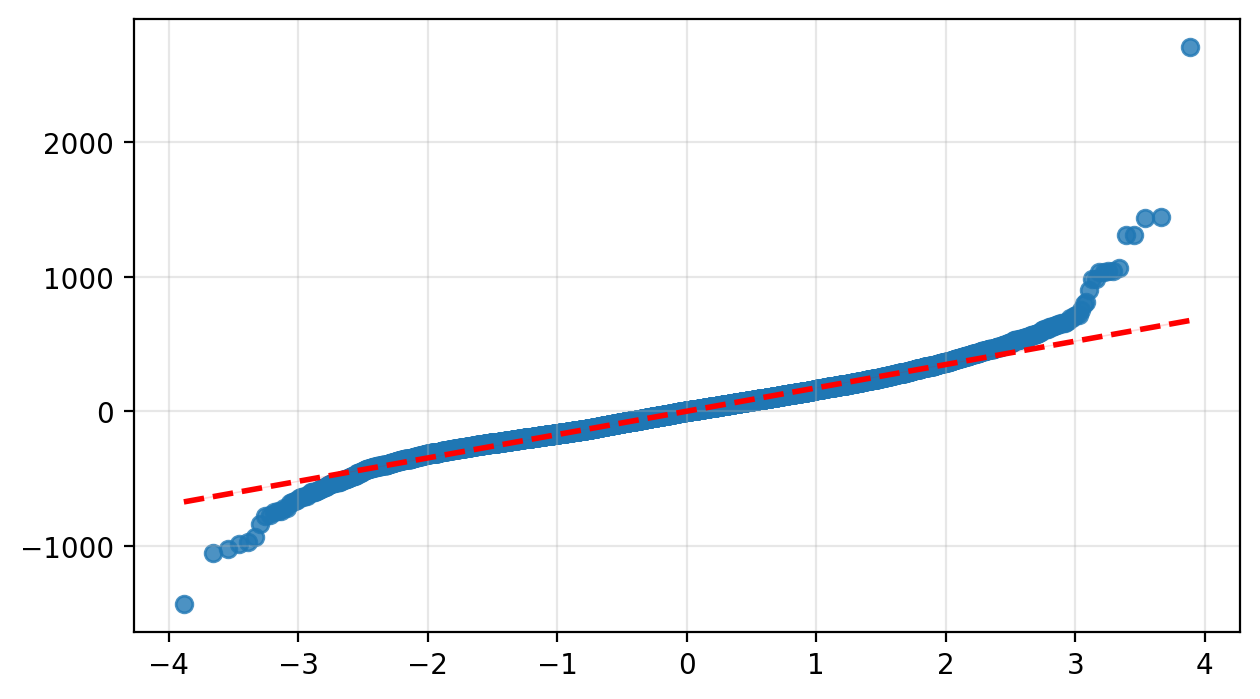

In [304]:
(x, y), _ = probplot(fit.resid)
# 1) 그래프 초기화
width_px = 1280  # 그래프 가로 크기
height_px = 720  # 그래프 세로 크기
rows = 1  # 그래프 행 수
cols = 1  # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
# 2) regplot 그리기
sb.regplot(
    x=x, y=y, line_kws={"color": "red", "linestyle": "--", "linewidth": 2}  # 점선
)
# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3)  # 배경 격자 표시
# 4) 출력
plt.tight_layout()  # 여백 제거
plt.show()  # 그래프 화면 출력
plt.close()  # 그래프 작업 종료

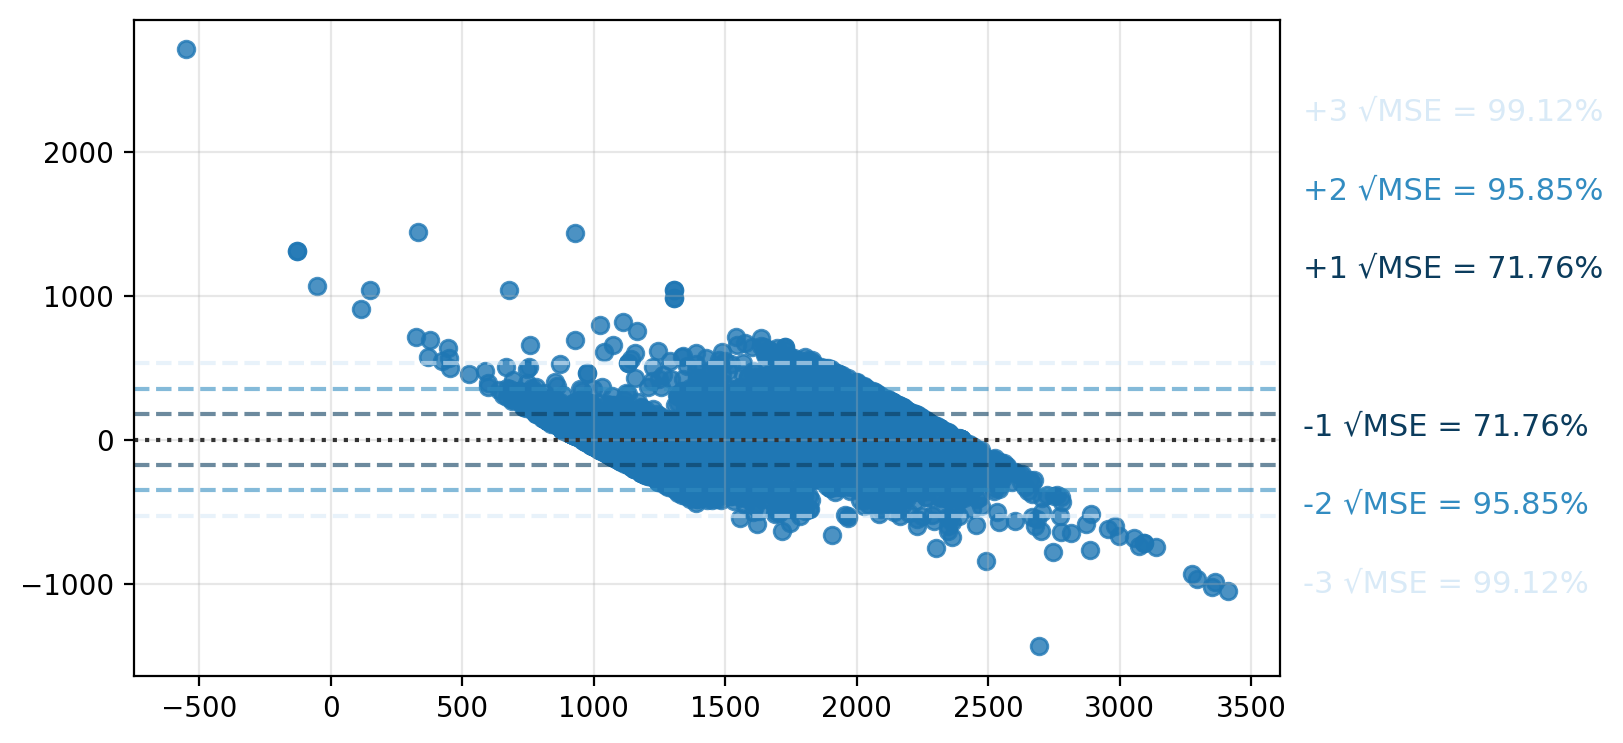

In [299]:
mse_sq = fit.mse_resid
mse_root = np.sqrt(mse_sq)
r = fit.resid  # 잔차

r1 = r[(r > -mse_root) & (r < mse_root)].count() / r.count() * 100
r2 = r[(r > -2 * mse_root) & (r < 2 * mse_root)].count() / r.count() * 100
r3 = r[(r > -3 * mse_root) & (r < 3 * mse_root)].count() / r.count() * 100

mse_r = [r1, r2, r3]

mse_r = [r1, r2, r3]
colors = ["#0B3C5D", "#328CC1", "#D9EAF7"]
xmax = fit.fittedvalues.max()
ymin = fit.fittedvalues.min()
# 1) 그래프 초기화
width_px = 1600
height_px = 720
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi, constrained_layout=True)
# 2) seaborn 기본 잔차도
sb.residplot(x=fit.fittedvalues, y=fit.resid)
# 3) 꾸미기
ax.grid(True, alpha=0.3)
# 4) MSE 3단계 표시
for i, c in enumerate(colors):
    k = i + 1
    # 올바른 ±k√MSE 위치
    y_pos = k * mse_root
    ax.axhline(y=y_pos, color=c, linestyle="--", alpha=0.6)
    ax.axhline(y=-y_pos, color=c, linestyle="--", alpha=0.6)
    # 텍스트는 축 좌표계 사용 (그래프 밖으로 안 나감)
    ax.text(
        x=1.02,
        y=0.5 + 0.12 * k,
        s=f"+{k} √MSE = {mse_r[i]:0.2f}%",
        transform=ax.transAxes,
        ha="left",
        va="center",
        fontsize=11,
        color=c,
    )
    ax.text(
        x=1.02,
        y=0.5 - 0.12 * k,
        s=f"-{k} √MSE = {mse_r[i]:0.2f}%",
        transform=ax.transAxes,
        ha="left",
        va="center",
        fontsize=11,
        color=c,
    )
# 5) 출력
plt.show()
plt.close()

In [287]:
if len(df13) < 5000:
    method = "Shapiro-Wilk"
    stat, p = shapiro(fit.resid)
    print(f"{method} statistic: {stat:.4f}, p-value: {p:.4f}")
    violated = p < 0.05
else:
    method = "Anderson-Darling"
    ad_res = anderson(fit.resid, dist="norm")
    crit_levels = ad_res.significance_level.tolist()
    crit_values = ad_res.critical_values.tolist()
    crit_5 = crit_values[crit_levels.index(5.0)] if 5.0 in crit_levels else None
    print(f"{method} statistic: {ad_res.statistic:.4f}, 5% 임계값: {crit_5:.4f}")
    violated = crit_5 is not None and ad_res.statistic > crit_5
print(
    "정규성 가정 위배 가능성이 있음 (5% 유의수준)"
    if violated
    else "정규성 가정 위배 근거 없음 (5%유의수준)"
)

Anderson-Darling statistic: 22.1035, 5% 임계값: 0.7870
정규성 가정 위배 가능성이 있음 (5% 유의수준)


In [288]:
# Breusch–Pagan Test
names = ["LM Statistic", "LM p-value", "F Statistic", "F p-value"]
bp_test = het_breuschpagan(fit.resid, fit.model.exog)
bp = DataFrame(bp_test, index=names, columns=["value"])
# p-value는 F p-value를 기준으로 사용
p_bp = bp.loc["F p-value", "value"]
print(
    f"Breusch–Pagan statistic: {bp.loc['F Statistic','value']:.3f}, p-value ={p_bp:.3f}"
)
print(f"{'이분산성 존재(등분산 아님)' if p_bp <= 0.05 else '등분산성 만족'}")

Breusch–Pagan statistic: 31.867, p-value =0.000
이분산성 존재(등분산 아님)


In [289]:
dw = durbin_watson(fit.resid)
if 1.5 <= dw <= 2.5:
    interpretation = "잔차는 독립성을 만족함 (자기상관 없음)"
elif dw < 1.5:
    interpretation = "잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)"
else:
    interpretation = "잔차에 음(–)의 자기상관이 존재할 가능성 있음 (독립성 위반)"
print(f"Durbin–Watson: {dw:.3f}")
print(interpretation)

Durbin–Watson: 1.176
잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)


In [290]:
m

'price에 대하여 carat,y,z,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(20,13441) = 3718., p ≤ 0.05).'

In [291]:
print("\n".join(v))

carat의 회귀계수는 4538.0005(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
y의 회귀계수는 30.8569(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
z의 회귀계수는 16.2041(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Good의 회귀계수는 85.7348(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Ideal의 회귀계수는 190.2934(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Premium의 회귀계수는 165.2761(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Very Good의 회귀계수는 137.3148(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_E의 회귀계수는 -86.7441(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_F의 회귀계수는 -141.7666(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_G의 회귀계수는 -203.0090(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_H의 회귀계수는 -315.5705(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_I의 회귀계수는 -473.6706(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_J의 회귀계수는 -669.1618(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
clarity_IF의 회귀계수는 1630.9537(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
clarity_SI1의 회귀계수는 1035.5176(p ≤ 0.05)로, p